#### Update for v1.1
- v1.0 was valid to work
- v1.1 added doPrediction for predict whole CT scan as in test setting. 

# Configuration

In [1]:
# !pip install monai
# !pip install nibabel
# !pip install SimpleITK
# !pip install tensorboard

In [1]:
MODEL_TO_LOAD = ''
FN_LOSS = 0
LEVELS = 6
FILTER_NUM = 24
TRAINING_NAME = f'3D_Unet_DropRes_lv{LEVELS}_192+_Filter{FILTER_NUM}'
TB_PREFIX = 'bonemeta_small_label' + '_{}'.format(TRAINING_NAME)

PATCH_SIZE = 192

# BATCH_SIZE = 120
BATCH_SIZE = 1
EPOCHS = 1500

BASE_DIR = '/workspace/BoneMeta_192+'
IMG_FOLDER_NAME = 'images'
LABEL_FOLDER_NAME = 'small_labels_V'

In [2]:
import os
import sys
import hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
import random

# Set dataset

In [3]:
# !git clone https://github.com/JungOhLee/bonemeta_model.git ./git_clone
# !mv  -v ./git_clone/* .

In [4]:
IMG_DIR = os.path.join(BASE_DIR, IMG_FOLDER_NAME)
LABEL_DIR = os.path.join(BASE_DIR, LABEL_FOLDER_NAME)

IMG_FILES = os.listdir(IMG_DIR)
LABEL_FILES = os.listdir(LABEL_DIR)

def get_img_path(file): 
    return os.path.join(IMG_DIR, file)

def get_label_path(file):
    return os.path.join(LABEL_DIR, file)

def case_to_file(case):
    return case+'.npy'

def file_to_case(file_name):
    return file_name.split('.')[0]

set(IMG_FILES).issubset(LABEL_FILES)

True

In [5]:
print(IMG_DIR, len(IMG_FILES))
print(LABEL_DIR, len(LABEL_FILES))

/workspace/BoneMeta_192+/images 485
/workspace/BoneMeta_192+/small_labels_V 487


In [6]:
len(set(IMG_FILES)-set(LABEL_FILES))

0

In [7]:
# # z축 작은 녀석들만 남기기 
# SMALL_Z_CASES = ['000251_20190703_chest', '000356_20191024_chest', '000350_20190927_chest', '000397_20200214_chest', 'BH005_20170701_abdomen', 'BH041_20190201_C-T-L Spine (3D)', 'BH005_20170701_chest', '000355_20190901_abdomen', '000022_20180830_chest', '000244_20190501_abdomen', '000332_20191025_chest', '000019_20181018_chest', 'BH011_20190301_Spine^00_C_Spine_Pre_OP (Adult)', '000019_20190613_chest', 'BH017_20191201_abdomen', '000273_20190531_chest', '000404_20200305_chest', '000286_20190701_abdomen', 'SN015_20190901_chest', '000391_20200216_Thoracic Aorta CT Angio+3D (contrast)', '000262_20190501_abdomen', 'SN013_20190401_chest', '000285_20190807_chest', '000362_20191201_abdomen', '000322_20190913_chest', 'BH057_20191227_chest', '000400_20200210_chest', 'BH064_20200605_abdomen', 'BH034_20190901_chest', '000298_20190726_chest', '000311_20190902_chest', '000396_20200201_abdomen', '000223_20190319_chest', 'BH032_20180701_abdomen', '000291_20190701_abdomen', 'BH045_20181001_abdomen', '000296_20190726_chest', 'BH066_20190525_chest', 'BH010_20161101_chest', '000251_20190701_abdomen', 'SN007_20190701_chest', '000193_20190114_chest', '000262_20190529_chest', '000251_20190429_chest', 'BH060_20200413_chest', '000234_20190419_chest', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism) (2)', 'BH070_20160823_chest', '000316_20190627_chest', '000356_20190901_abdomen', '000383_20200121_chest', 'BH052_20190901_chest', '000450_20200512_chest', '000276_20190604_chest', '000364_20191217_chest', 'BH025_20191101_abdomen', 'BH035_20191101_GU Kidney & bladder CT (3D)', 'BH018_20190801_chest', '000269_20190601_abdomen', 'BH008_20190701_chest', '000332_20191001_abdomen', 'BH043_20191001_abdomen', '000260_20190522_chest', 'BH007_20190801_chest', 'BH067_20191017_chest', '000279_20190614_chest', 'SN004_20190901_chest', 'BH042_20180801_C-T-L Spine (3D)', 'BH099_20200806_abdomen', 'BH055_20200328_chest', 'BH001_20190401_chest', '000162_20180131_chest', 'BH054_20191122_abdomen', '000450_20200501_abdomen', 'BH030_20160101_T-L spine (3D)', '000372_20200107_chest', 'BH069_20200505_chest', 'BH012_20180401_abdomen', 'BH058_20180918_chest', '000404_20200201_abdomen', 'BH048_20190501_chest', '000348_20191201_CT Liver (contrast)', 'BH002_20190701_chest', '000376_20200101_abdomen', '000309_20190801_abdomen', 'SN017_20190701_chest', 'BH029_20200101_chest', 'BH059_20201013_abdomen', '000310_20190801_abdomen', '000272_20190614_chest', 'BH027_20191001_L-spine CT (3D)', 'BH064_20200605_chest', '000350_20191001_abdomen', '000232_20190423_chest', 'BH001_20190501_abdomen', 'BH039_20190601_chest', 'SN008_20190901_chest', '000270_20190608_chest', 'BH091_20200104_chest', '000269_20190604_chest', '000331_20190916_chest', '000325_20190919_chest', '000363_20191222_chest', '000260_20190501_CT Liver (contrast)', '000330_20190926_chest', 'BH072_20200219_abdomen', '000324_20190910_chest', 'BH009_20180301_chest', 'BH028_20190801_chest', 'SN029_20200301_chest', 'BH110_20200616_chest', '000401_20200201_T-Spine+3D CT (noncontrast)', 'SN031_20160501_chest', 'SN005_20191101_chest', '000452_20200513_chest', '000021_20181227_chest', '000236_20190401_abdomen', 'SN002_20190801_chest', '000382_20200129_chest', '000301_20190801_Pulmonary artery CT Angio+3D (contrast)', 'BH015_20190101_chest', 'BH043_20191001_chest', 'BH063_20200519_chest', '000363_20191201_abdomen', '000354_20191001_abdomen', 'BH047_20180901_abdomen', '000079_20180911_Pulmonary artery CT Angio+3D (contrast)', 'BH016_20151001_chest', 'BH061_20190315_abdomen', 'BH014_20181201_chest', '000362_20191214_chest', '000354_20191022_chest', 'SN051_20170401_chest', 'SN036_20190601_chest', 'BH017_20191201_chest', '000282_20190701_abdomen', 'BH023_20191101_chest', '000085_20180829_chest', 'SN019_20190801_chest', '000212_20190324_chest', '000302_20190726_chest', 'BH009_20180301_abdomen', 'BH008_20190701_abdomen', '000301_20190801_abdomen', 'BH015_20190101_abdomen', 'SN028_20160801_chest', '000344_20191125_chest', 'BH014_20181201_abdomen', '000214_20190325_chest', '000386_20200204_chest', '000372_20200101_abdomen', 'BH091_20200104_GU Kidney & bladder CT (3D)', 'SN025_20200401_chest', '000400_20200201_CT Biliary (contrast)', '000255_20190418_chest', 'BH081_20190322_abdomen', '000315_20190820_chest', '000288_20190701_abdomen', '000272_20190601_abdomen', '000322_20190901_abdomen', '000331_20190901_abdomen', 'SN055_20170301_chest', 'BH052_20190901_abdomen', '000310_20190812_chest', '000069_20180319_chest', 'BH024_20190501_abdomen', 'BH021_20181001_abdomen', '000009_20180417_chest', 'BH037_20171101_abdomen', '000002_20180829_chest', '000234_20190401_abdomen', '000262_20190318_chest', 'SN016_20190901_chest', '000232_20190401_abdomen', 'SN056_20170601_Thorax^01_Lung_Cancer_3D (Adult)', '000300_20190801_abdomen', 'BH006_20170801_chest', '000278_20190620_chest', 'BH036_20180301_GU Kidney & bladder CT (3D)', 'BH019_20191101_chest', 'BH004_20191101_chest', '000382_20200101_abdomen', '000242_20190409_chest', 'BH061_20190315_chest', '000080_20180911_chest', '000355_20191023_chest', '000364_20191201_abdomen', 'BH018_20190801_abdomen', '000291_20190718_chest', '000279_20190601_abdomen', '000308_20190826_chest', '000305_20190801_abdomen', 'BH010_20161101_abdomen', 'BH007_20190801_abdomen', 'BH021_20181001_chest', '000396_20200218_chest', '000091_20180504_chest', 'SN042_20170901_chest', '000314_20190827_chest', 'BH031_20160301_CT Angio + 3D Pulmonary artery (Embolism)', 'BH023_20191101_abdomen', '000301_20190827_chest', 'BH062_20201104_chest', 'BH020_20191201_chest', 'BH059_20201019_chest', '000246_20190629_chest', 'BH026_20190601_abdomen', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism)', 'BH034_20190901_abdomen', 'BH099_20200806_chest', 'BH051_20190301_GU Kidney & bladder CT (3D)', '000368_20200101_abdomen', 'BH057_20191227_abdomen', 'BH112_20190201_chest', 'BH024_20190501_chest', 'BH013_20191001_chest', '000309_20190823_chest', '000011_20181207_chest', 'BH020_20191201_abdomen', 'BH027_20191001_chest', '000316_20190715_Spine^L_SPINE (Adult)', '000012_20181214_chest', 'BH032_20180701_chest', 'BH037_20171101_chest', '000285_20190801_abdomen', 'BH038_20160901_CT angio + 3D C-spine(vertebral artery, C1-2)', 'BH072_20200219_chest', 'SN054_20170201_chest', '000048_20190501_abdomen', '000304_20190124_chest', 'BH045_20181001_chest', '000352_20191001_abdomen', 'BH016_20151001_abdomen', 'BH022_20190101_chest', 'BH047_20180901_chest', '000314_20190901_abdomen', 'BH065_20201013_chest', 'BH056_20200721_chest', '000281_20190701_chest', '000025_20180808_chest', '000352_20191017_chest', 'BH012_20180401_chest', '000224_20190228_chest', '000308_20190801_abdomen', '000376_20200114_chest']
# SMALL_Z_FILES = [case_to_file(case) for case in SMALL_Z_CASES]
# IMG_FILES = list(set(IMG_FILES).intersection(SMALL_Z_FILES))
# len(IMG_FILES)

In [8]:
TRAIN_FILES = ['BH032_20180701_Chest CT (contrast) + 3D (Breast with other CT).npy', 'BH120_20200406_Abdomen & pelvis CT (3D).npy', 'BH007_20190801_Abdomen & pelvis CT (3D).npy', 'BH107_20200510_Chest CT (Contrast) + 3D(TS).npy', '000278_20190620_Chest CT (contrast).npy', 'SN096_20000101_CT Chest + 3D (contr.npy', '000244_20190501_CT Abdomen+Pelvis Post (contrast).npy', 'BH075_20200721_Chest CT (Contrast) + 3D(Breast).npy', '000348_20191201_CT Liver (contrast).npy', 'SN013_20190401_CT Chest + 3D (contr.npy', 'SN039_20181001_CT Chest Breast Cancer (contrast).npy', '000269_20190601_CT Abdomen+Pelvis Dynamic (contrast).npy', '000423_20200401_CT Abdomen+Pelvis Dynamic (contrast).npy', '000269_20181214_CT Abdomen+Pelvis Dynamic (contrast).npy', 'BH034_20190923_GU OBGY,Abd-pelvis CT(pre&post) (3D).npy', 'SN056_20170601_Thorax^01_Lung_Cancer_3D (Adult).npy', 'SN014_20190901_Chest Routine(contrast).npy', 'BH031_20160301_CT Angio + 3D Pulmonary artery (Embolism).npy', 'BH114_20180920_GU Kidney & bladder CT (3D).npy', 'BH024_20190501_Abdomen & pelvis CT (3D).npy', 'SN043_20170701_CT Chest Breast Cancer (contrast_NO CM).npy', 'BH009_20180301_Abdomen & pelvis CT (3D).npy', '000376_20200114_Chest CT (contrast).npy', 'BH078_20200522_Abdomen & pelvis CT (3D).npy', '000255_20190418_Chest CT (contrast).npy', 'SN049_20170901_CT Chest Breast Canc.npy', '000372_20200101_CT Abdomen+Pelvis Dynamic (contrast).npy', 'BH022_20190101_Thorax^03_Chest_NON (Adult).npy', '000300_20190801_CT Abdomen+Pelvis Post (contrast).npy', 'SN005_20191001_Abdomen^03_LIVER (Adult).npy', '000085_20180829_Chest CT (contrast).npy', 'BH123_20201023_Chest CT (contrast) + 3D (Chest with other CT).npy', '000492_20210329_Chest CT (contrast).npy', 'SN014_20190901_CT Abdomen+Pelvis Arterial+Portal 3D (contrast).npy', 'SN085_20000101_Thorax^02_Chest3D (Adult).npy', 'BH061_20190315_Chest CT (contrast) + 3D (Chest with other CT).npy', 'BH092_20201117_GU Kidney & bladder CT (3D).npy', 'SN096_20000101_CT Abdomen+Pelvis Ar.npy', '000396_20200201_CT Abdomen+Pelvis Dynamic (contrast).npy', 'SN011_20180401_CT Abdomen+Pelvis Arterial+Portal (contrast).npy', 'BH015_20190101_Chest CT (contrast) + 3D (Breast with other CT).npy', 'BH073_20201223_Abdomen & pelvis CT.npy', '000363_20191201_CT Abdomen+Pelvis Pre-Post (contrast).npy', 'SN028_20160801_CT Chest + 3D (contrast).npy', 'SN018_20190801_CT Abdomen+Pelvis Ar.npy', '000285_20190801_CT Abdomen+Pelvis Pre-Post (contrast).npy', '000492_20210401_CT Abdomen+Pelvis Pre-Post (contrast).npy', '000009_20180417_Chest CT (contrast).npy', 'BH098_20200626_GU Kidney & bladder CT (3D).npy', '000466_20210125_Chest CT (contrast).npy', 'BH057_20191227_Chest CT (contrast) + 3D (Chest with other CT).npy', 'SN059_20170501_CT Chest Breast Cancer (contrast).npy', 'SN108_20000101_CT Chest + 3D (contr.npy', 'BH037_20171125_Abdomen & pelvis CT (3D).npy', 'SN055_20170301_CT Chest Low Dose +.npy', 'BH012_20180401_Chest CT (contrast) + 3D (Chest with other CT).npy', '000234_20190401_CT Abdomen+Pelvis Dynamic (contrast).npy', '000331_20190901_CT Abdomen+Pelvis Post (contrast).npy', 'BH114_20180920_Chest CT (contrast) + 3D (Chest with other CT).npy', 'SN100_20000101_CT Liver+Pelvis(contrast).npy', '000236_20190401_CT Abdomen+Pelvis Post (contrast).npy', '000404_20200305_Chest CT (contrast).npy', '000533_20210507_CT Liver (contrast).npy', 'BH087_20190314_Abdomen & pelvis CT (3D).npy', '000269_20181016_CT Abdomen+Pelvis Dynamic (contrast).npy', '000048_20190501_CT Abdomen+Pelvis Uro (contrast).npy', 'BH113_20170914_Liver CT (LC or CLD, 3D).npy', 'BH081_20190322_Abdomen & pelvis CT (3D).npy', '000560_20210706_CT Abdomen+Pelvis Dynamic (contrast).npy', '000224_20190228_Chest CT (contrast).npy', '000304_20190124_Chest CT (contrast).npy', 'SN051_20170401_CT Abdomen+Pelvis Arterial+Portal (contrast).npy', 'BH024_20190501_Chest CT (contrast) + 3D (Breast with other CT).npy', 'SN101_20000101_Thorax^04_Chest_3D (Adult).npy', 'BH034_20190901_Chest CT (contrast) + 3D (Chest with other CT).npy', '000308_20190801_CT Abdomen+Pelvis Post (contrast).npy', 'SN031_20160501_2-CT Chest Lung cancer.npy', '000364_20191201_CT Abdomen+Pelvis Dynamic.npy', '000417_20200331_Chest CT (contrast).npy', '000530_20210428_Chest CT (contrast).npy', '000400_20200201_CT Biliary (contrast).npy', 'BH014_20181201_Chest CT (contrast) + 3D (Chest with other CT).npy', 'BH098_20200626_Chest CT (contrast) + 3D (Chest with other CT).npy', '000314_20190827_Chest CT (contrast).npy', 'SN046_20170601_CT Abdomen+Pelvis Arterial+Portal (contrast).npy', 'SN079_20000101_CT Liver+Pelvis(contrast).npy', 'SN025_20200401_CT Chest + 3D (contr.npy', 'SN055_20170301_CT Abdomen+Pelvis Ar.npy', 'BH043_20191001_Abdomen & pelvis CT (3D).npy', 'BH016_20151001_Abdomen & pelvis CT (3D).npy', '000017_20180524_CT Stomach (contrast).npy', 'BH016_20151001_Chest CT (contrast) + 3D (Chest with other CT).npy', 'BH120_20200304_Chest CT (contrast) + 3D.npy', '000272_20190601_CT Abdomen+Pelvis Dynamic (contrast).npy', 'BH012_20180401_Abdomen & pelvis CT (3D).npy', '000520_20200917_Chest CT (contrast).npy', 'BH018_20190801_Chest CT (contrast) + 3D (Breast with other CT).npy', '000025_20180808_CT Abdomen+Pelvis Dynamic (contrast).npy', 'SN104_20000101_CT Chest Lung cancer+3D(contrast).npy', '000435_20200420_Chest CT (contrast).npy', 'SN051_20170401_CT Chest + 3D (contrast_NO CM).npy', 'BH007_20190801_Chest CT (contrast) + 3D (Chest with other CT).npy', '000383_20200121_Chest CT (contrast).npy', 'BH080_20181210_Abdomen & pelvis CT (3D).npy', '000269_20190604_Chest CT (contrast).npy', '000234_20190419_Chest CT (contrast).npy', 'SN042_20170901_CT Abdomen+Pelvis 3D.npy', 'BH061_20190315_Abdomen & pelvis CT (3D).npy', 'SN017_20190701_Thorax^05_Chest_Lung_Cancer_3D (Adult).npy', 'BH070_20160823_Abdomen & pelvis CT (3D).npy', '000423_20200407_Chest CT (contrast).npy', 'BH023_20191101_Abdomen & pelvis CT (3D).npy', '000242_20190409_Chest CT (contrast).npy', 'SN009_20190801_CT Chest Breast Canc.npy', '000011_20181207_Chest CT (contrast).npy', '000019_20190613_Chest CT (contrast).npy', 'BH065_20201013_Low dose Chest CT + 3D(insured).npy', 'SN039_20181001_CT Abdomen+Pelvis Arterial+Portal (contrast).npy', '000362_20191201_CT Abdomen+Pelvis Dynamic (contrast).npy', '000386_20200204_Chest CT (contrast).npy', 'BH006_20170801_Chest CT (Contrast) + 3D(Breast).npy', 'BH008_20190701_Chest CT (contrast) + 3D (Chest with other CT).npy', 'SN108_20000101_CT Abdomen+Pelvis (c.npy', 'SN088_20000101_CT Chest Breast Cancer (contrast).npy', 'BH100_20201007_Thorax^02_Chest_CON (Adult).npy', 'SN063_20000101_CT Chest + 3D (contrast_NO CM).npy', 'BH009_20180301_Chest CT (contrast) + 3D (TS with other CT).npy', 'SN010_20190801_CT Liver+Pelvis(contrast).npy', 'BH008_20190701_Abdomen & pelvis CT (3D).npy', '000305_20190801_CT Acute Abdomen (contrast).npy', 'SN067_20000101_CT Liver+Pelvis(contrast).npy', 'SN005_20191101_CT Chest + 3D (contr.npy', 'BH057_20191227_Abdomen & pelvis CT (3D).npy', '000298_20190726_Chest CT (contrast).npy', '000494_20210405_Chest CT (contrast).npy', 'BH120_20200406_Chest CT (contrast) + 3D (Chest with other CT).npy', 'BH060_20200413_Chest CT (contrast) + 3D.npy', '000304_20190124_CT Liver (contrast).npy', 'SN007_20190801_CT Abdomen+Pelvis Ar.npy', 'BH081_20190322_Chest CT (contrast) + 3D (Chest with other CT).npy', 'BH037_20171125_Chest CT (contrast) + 3D (Chest with other CT).npy', 'BH072_20200219_Chest CT (contrast) + 3D (Chest with other CT).npy', '000362_20191214_Chest CT (contrast).npy', '000331_20190916_Chest CT (contrast).npy', '000232_20190401_CT Abdomen+Pelvis Dynamic (contrast).npy', '000560_20210706_Chest CT (contrast).npy', '000288_20190701_CT Abdomen+Pelvis Dynamic (contrast).npy', 'SN078_20000101_Thorax^01_Chest3D_Non_New (Adult).npy', '000497_20201130_CT Liver (contrast).npy', 'BH010_20161101_Chest CT (contrast) + 3D (Breast with other CT).npy', 'BH111_20161020_CT Angio + 3D Coronary, Chest.npy', 'SN106_20000101_CT Chest + 3D (contrast).npy', '000382_20200129_Chest CT (contrast).npy', 'BH017_20191201_Abdomen & pelvis CT (3D).npy', '000281_20190701_Chest CT (contrast).npy', '000286_20190710_[외부 CT 19-07-10]Chest CT contrast.npy', 'BH005_20170701_Chest CT (contrast) + 3D (Breast with other CT).npy', '000404_20200201_CT Abdomen+Pelvis Dynamic (contrast).npy', 'BH089_20200803_Chest CT (Contrast) + 3D(TS).npy', '000022_20180830_Chest CT (contrast).npy', 'BH017_20191201_Chest CT (contrast) + 3D (Chest with other CT).npy', '000506_20201113_Chest CT (contrast).npy', 'SN044_20160601_CT Liver+Pelvis(contrast).npy', 'SN026_20180401_CT Abdomen+Pelvis Arterial+Portal (contrast).npy', '000272_20190614_Chest CT (contrast).npy', '000355_20190901_CT Abdomen+Pelvis Dynamic (contrast).npy', 'SN098_20000101_CT Abdomen+Pelvis Arterial+Portal 3D (contrast).npy', '000529_20210416_Chest CT (contrast).npy', 'SN028_20160801_CT Abdomen+Pelvis 3D (contrast).npy', '000541_20210520_Chest CT (contrast).npy', 'BH109_20181210_Chest CT (contrast) + 3D (Breast with other CT).npy', '000481_20210409_CT Liver (contrast).npy', 'BH039_20190626_Chest CT (Contrast) + 3D(TS).npy', '000311_20190902_Chest CT (contrast).npy', 'SN079_20000101_CT Chest Low Dose + 3D (noncontrast).npy', 'BH056_20200721_Chest CT (contrast) + 3D.npy', 'SN034_20200101_CT Abdomen+Pelvis Ar.npy', 'BH116_20180606_GU Abdomen & pelvis CT (3D).npy', '000286_20190701_CT Abdomen+Pelvis Dynamic (contrast).npy', 'SN041_20170201_CT Chest Routine (contrast).npy', '000565_20210806_Chest CT (contrast).npy', 'SN067_20000101_CT Chest + 3D (contrast_NO CM).npy', 'SN063_20000101_CT Abdomen+Pelvis 3D (contrast).npy', 'SN016_20190901_CT Abdomen+Pelvis Ar.npy', '000223_20190319_Chest CT (contrast).npy', 'SN009_20190801_CT Abdomen+Pelvis Ar.npy', 'BH062_20201104_Chest CT (contrast) + 3D (Chest with other CT).npy', '000330_20190926_Chest CT (contrast).npy', 'SN025_20200401_CT Abdomen+Pelvis Ar.npy', 'BH025_20191101_Abdomen & pelvis CT (3D).npy', 'BH059_20201019_Chest CT (contrast) + 3D.npy', 'BH089_20200811_Abdomen & pelvis CT.npy', '000193_20190114_Chest CT (contrast).npy', 'BH086_20190812_Chest CT (Contrast) + 3D(TS).npy', 'BH020_20191201_Chest CT (Non contrast) + 3D.npy', 'BH027_20191001_Chest CT (Contrast) + 3D(TS).npy', '000019_20181018_Chest CT (contrast).npy', 'BH110_20200616_Chest CT (contrast) + 3D (Chest with other CT).npy', '000324_20190910_Chest CT (contrast).npy', '000246_20190629_Chest CT (contrast).npy', '000506_20201110_CT Urography (contrast).npy', '000400_20200210_Chest CT (contrast).npy', '000370_20200117_Chest CT (contrast).npy', '000450_20200501_CT Abdomen+Pelvis Post (contrast).npy', '000382_20200101_CT Abdomen+Pelvis Post (contrast).npy', 'SN084_20000101_CT Chest + 3D (contrast).npy', '000494_20210405_CT Acute Abdomen (contrast).npy', '000309_20190823_Chest CT (contrast).npy', 'SN068_20000101_CT Chest + 3D (contrast_NO CM).npy', 'BH043_20191001_Chest CT (contrast) + 3D (Chest with other CT).npy', 'SN034_20200101_CT Chest Breast Canc.npy', 'SN100_20000101_CT Chest Low Dose + 3D (noncontrast).npy', 'BH070_20160823_Chest CT (contrast) + 3D (Chest with other CT).npy', 'BH083_20200629_Abdomen & pelvis CT (non-contrast 3D).npy', '000309_20190801_CT Abdomen+Pelvis Dynamic (contrast).npy', '000354_20191001_CT Abdomen+Pelvis Post (contrast).npy', 'SN087_20000101_Thorax^02_Lung_Cancer_3D (Adult).npy', '000019_20190601_CT Abdomen+Pelvis Dynamic (contrast).npy', 'BH014_20181201_Abdomen & pelvis CT (3D).npy', '000450_20200512_Chest CT (contrast).npy', '000302_20190726_Chest CT (contrast).npy', 'BH005_20170701_Abdomen & pelvis CT (3D).npy', '000370_20200101_CT Abdomen+Pelvis Post (contrast).npy', 'BH020_20191201_Abdomen & pelvis CT (non-contrast 3D).npy', '000363_20191222_Chest 3DCT (contrast).npy', 'BH073_20201223_Chest CT (contrast) + 3D (Chest with other CT).npy', 'SN070_20000101_Thorax^06_LowDose_New (Adult).npy', '000435_20200401_CT Abdomen+Pelvis Dynamic (contrast).npy', 'SN015_20190901_CT Abdomen + Pelvis.npy', 'BH013_20191001_Chest CT (contrast) + 3D (Chest with other CT).npy', '000466_20210128_CT Abdomen+Pelvis Post (contrast).npy', 'BH058_20180918_Chest CT (contrast) + 3D.npy', 'SN040_20170201_CT Abdomen+Pelvis Ar.npy', 'BH123_20201023_Abdomen & pelvis CT.npy', '000364_20191217_Chest CT (contrast).npy', '000481_20210305_Thorax^Lung_Pre (Adult).npy', '000315_20190820_[외부 CT 19-08-20]CT Chest Low dose spiral(폐암검진).npy', 'SN050_20170401_CT Chest Routine (co.npy', 'BH101_20201109_Chest CT (Contrast) + 3D(TS).npy', '000069_20180319_Chest CT (contrast).npy', 'BH001_20190501_Abdomen & pelvis CT (3D).npy', 'BH023_20191101_Chest CT (contrast) + 3D (Chest with other CT).npy', '000232_20190423_Chest CT (contrast).npy', 'BH055_20200328_Chest CT (contrast) + 3D (Chest with other CT).npy', 'SN013_20190401_CT Pelvis & Abdomen.npy', 'BH072_20200219_Abdomen & pelvis CT (3D).npy', '000280_19700101_CT Liver (contrast).npy', 'BH054_20191122_Abdomen^00_Liver_CT (Adult).npy', '000355_20191023_Chest CT (contrast).npy', 'BH019_20191101_Thorax^02_Chest_CON (Adult).npy', '000566_20210526_CT Abdomen+Pelvis Post (contrast).npy', '000021_20181227_Chest CT (contrast).npy', '000481_20200722_Chest CT (noncontrast).npy', 'BH085_20200801_Abdomen & pelvis CT.npy', 'SN064_20000101_CT Chest + 3D (contr.npy', 'BH051_20190301_GU Kidney & bladder CT (3D).npy', '000296_20190726_Chest CT (contrast).npy', 'SN015_20190901_CT Chest + 3D (contr.npy', 'SN031_20160501_CT Abdomen+Pelvis Ar.npy', 'BH059_20201013_Abdomen & pelvis CT.npy', 'SN018_20190801_CT Chest Breast Canc.npy', 'SN001_20190901_CT Abdomen+Pelvis 3D (noncontrast).npy', 'SN017_20190801_CT Abdomen+Pelvis Ar.npy', '000079_20180911_Pulmonary artery CT Angio+3D (contrast).npy', 'SN048_20170801_CT Chest Routine (contrast).npy', 'SN049_20170901_2-CT Abdomen+Pelvis Ar.npy', '000214_20190325_Chest CT (contrast).npy', '000372_20200107_Chest CT (contrast).npy', 'BH063_20200519_Chest CT (Non contrast) + 3D(Breast).npy', 'SN016_20190901_CT Chest + 3D (contr.npy', '000012_20181214_Chest CT (contrast).npy', '000486_20210309_Chest CT (contrast).npy', '000285_20190807_Chest CT (contrast).npy', 'BH010_20161101_Abdomen & pelvis CT (3D).npy', 'BH015_20190101_Abdomen & pelvis CT (3D).npy', '000091_20180504_Chest CT (contrast).npy', 'BH028_20190801_Chest CT (contrast) + 3D.npy', 'SN068_20000101_CT Abdomen+Pelvis Arterial+Portal (contrast).npy', '000011_20181207_CT Abdomen+Pelvis Post (contrast).npy', '000025_20180808_Chest CT (contrast).npy', 'BH048_20190501_Chest CT (contrast) + 3D (Breast with other CT).npy', '000436_20200401_CT Abdomen+Pelvis Dynamic (contrast).npy', '000396_20200218_Chest CT (contrast).npy', 'BH036_20180301_GU Kidney & bladder CT (3D).npy', 'BH116_20180606_Chest CT (contrast) + 3D (Breast with other CT).npy', 'SN008_20190901_CT Chest + 3D (contr.npy', '000276_20190604_Chest CT (contrast).npy', '000269_20190325_CT Abdomen+Pelvis Dynamic (contrast).npy', 'SN012_20150801_Abdomen^01_Abdomen_Pelvis_Chest (Adult).npy', 'SN007_20190701_Thorax^05_Chest_Lung_Cancer_3D (Adult).npy', 'SN042_20170901_CT Chest + 3D (contr.npy', '000533_20210521_Chest CT (contrast).npy', 'SN062_20000101_Thorax^01_Chest_Breast_Cancer (Adult).npy', '000308_20190826_Chest CT (contrast).npy', 'SN036_20190601_CT Chest + 3D (contr.npy', '000354_20191022_Chest CT (contrast).npy', 'BH032_20180701_Abdomen & pelvis CT (3D).npy', 'BH105_20160820_Chest CT (contrast) + 3D.npy', 'SN011_20180401_CT Chest Breast Cancer (contrast_NO CM).npy', 'BH066_20190525_Chest CT (contrast) + 3D (Chest with other CT).npy', '000376_20200101_CT Abdomen+Pelvis Dynamic (contrast).npy', '000301_20190801_CT Acute Abdomen (contrast).npy', '000301_20190801_Pulmonary artery CT Angio+3D (contrast).npy', '000301_20190827_Chest CT (contrast).npy', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism).npy', 'BH118_20200617_Liver CT (LC or CLD, 3D).npy', 'BH118_20200702_Chest CT (contrast) + 3D.npy', 'SN002_20190801_CT Abdomen+Pelvis Ar.npy', 'SN002_20190801_CT Chest + 3D (contr.npy', 'SN029_20200301_CT Chest + 3D (contrast).npy', 'SN029_20200301_CT Pelvis & Abdomen (URO & GY) (3P) (contrast).npy', 'SN032_20190501_CT Abdomen+Pelvis Arterial+Portal 3D (contrast).npy']

VAL_FILES = ['000368_20200101_CT Abdomen+Pelvis Dynamic (contrast).npy', '000262_20190501_CT Abdomen+Pelvis Post (contrast).npy', '000344_20191125_Chest CT (contrast).npy', 'BH079_20200921_Low dose Chest CT + 3D(insured).npy', 'BH104_20161219_Abdomen & pelvis CT (3D).npy', '000251_20190703_Chest CT (contrast).npy', '000251_20190429_Chest CT (contrast).npy', 'BH064_20200605_Abdomen & pelvis CT (3D).npy', '000212_20190324_Chest CT (noncontrast).npy', 'SN075_20000101_CT Chest + 3D (noncontrast).npy', '000528_20210514_Chest CT (contrast).npy', '000282_20190410_CT Abdomen+Pelvis Dynamic (contrast).npy', '000322_20190901_CT Abdomen+Pelvis Dynamic (contrast).npy', 'BH117_20180506_Chest CT (contrast) + 3D (Chest with other CT).npy', 'SN030_20191101_CT Abdomen+Pelvis Ar.npy', 'SN030_20191101_CT Chest + 3D (contr.npy', 'BH095_20200727_Abdomen & pelvis CT (3D).npy', 'BH117_20180506_Abdomen & pelvis CT (3D).npy', 'BH112_20190201_Chest CT (contrast) + 3D (Chest with other CT).npy', 'BH021_20181001_Abdomen & pelvis CT (3D).npy', '000317_20190720_CT Liver (contrast).npy', 'BH106_20200613_Chest CT (contrast) + 3D (Breast with other CT).npy', 'BH112_20190201_Abdomen & pelvis CT (3D).npy', '000005_20181202_CT Abdomen+Pelvis Dynamic (contrast).npy', '000162_20180131_Chest CT (contrast).npy', '000251_20190429_CT Abdomen+Pelvis Dynamic (contrast).npy', 'BH035_20191101_GU Kidney & bladder CT (3D).npy', 'SN092_20000101_Abdomen^01_Pancreatobiliary_Pre_OP_3D (Adult).npy', 'SN019_20190801_CT Abdomen+Pelvis Ar.npy', 'SN090_20000101_CT Chest Lung cancer.npy', 'SN019_20190801_CT Chest + 3D (contr.npy', '000262_20190318_Chest CT (contrast).npy', 'BH074_20201113_Abdomen^00_Abd_CT (Adult).npy', '000080_20180911_Chest CT (contrast).npy', 'SN020_20190801_CT Chest Breast Cancer (contrast_NO CM).npy', '000282_20190701_CT Abdomen+Pelvis Post (contrast).npy', 'BH119_20200227_Chest CT (contrast) + 3D.npy', 'SN091_20000101_CT Abdomen+Pelvis Ar.npy', 'BH104_20161219_Chest CT (contrast) + 3D (Chest with other CT).npy', '000557_20210621_CT Abdomen+Pelvis Post (contrast).npy', '000262_20190529_Chest CT (contrast).npy', 'SN020_20190801_CT Abdomen+Pelvis Arterial+Portal (contrast).npy', '000322_20190913_Chest CT (contrast).npy', '000279_20190614_Chest 3DCT (contrast).npy', 'SN054_20170201_CT Chest Lung cancer+3D(contrast).npy', 'BH021_20181001_Chest CT (contrast) + 3D (Chest with other CT).npy', '000251_20190701_CT Abdomen+Pelvis Dynamic (contrast).npy', 'BH106_20200613_Abdomen & pelvis CT (3D).npy', '000316_20190715_Spine^L_SPINE (Adult).npy', 'BH119_20200303_Abdomen & pelvis CT (3D).npy', 'BH064_20200605_Chest CT (contrast) + 3D (Chest with other CT).npy', '000316_20190627_Chest CT (contrast).npy', '000262_20190319_CT Abdomen+Pelvis Dynamic (contrast).npy', 'SN092_20000101_CT Chest + 3D (contrast).npy']

TEST_FILES = ['000510_20201124_CT Abdomen+Pelvis Dynamic (contrast).npy', 'BH071_20160826_Chest CT (contrast) + 3D.npy', 'BH108_20180228_Chest CT (contrast) + 3D.npy', 'SN083_20000101_CT Chest + 3D (contrast).npy', '000332_20191001_CT Abdomen+Pelvis Dynamic (contrast).npy', 'BH045_20181001_Chest CT (contrast) + 3D (Chest with other CT).npy', 'SN093_20000101_CT Chest + 3D (contrast).npy', 'BH121_20200301_Abdomen & pelvis CT (3D).npy', 'SN035_20180101_CT Stomach+Pelvis Arterial+Portal(contrast).npy', 'SN094_20000101_CT Chest + 3D (contr.npy', '000475_20210210_Chest CT (contrast).npy', '000452_20200501_CT Abdomen+Pelvis Dynamic (contrast).npy', 'BH090_20200924_Abdomen & pelvis CT.npy', 'BH026_20190601_Abdomen & pelvis CT (3D).npy', '000010_20181214_CT Abdomen+Pelvis Dynamic (contrast).npy', 'BH067_20191017_Chest CT (contrast) + 3D (Chest with other CT).npy', 'SN060_20170901_CT Chest Breast Cancer (contrast_NO CM).npy', '000409_20200310_Chest CT (contrast).npy', 'BH082_20200416_Chest CT (contrast) + 3D.npy', '000291_20190718_Chest CT (contrast).npy', 'BH029_20200101_Chest HRCT (lung cancer).npy', '000510_20201120_Chest CT (contrast).npy', 'BH091_20200104_GU Kidney & bladder CT (3D).npy', '000356_20190901_CT Abdomen+Pelvis Dynamic (contrast).npy', 'BH047_20180901_Abdomen & pelvis CT (3D).npy', '000260_20190501_CT Liver (contrast).npy', 'BH099_20200806_Abdomen & pelvis CT.npy', 'SN004_20190801_CT Abdomen+Pelvis Ar.npy', 'SN004_20190901_CT Chest + 3D (contrast).npy', '000350_20191001_CT Abdomen+Pelvis Dynamic (contrast).npy', 'BH052_20190901_Abdomen & pelvis CT (3D).npy', 'SN094_20000101_CT Abdomen+Pelvis Ar.npy', '000310_20190812_Chest CT (contrast).npy', 'BH121_20200301_Chest CT (contrast) + 3D (Chest with other CT).npy', 'BH045_20181001_GU Abdomen & pelvis CT (3D).npy', '000291_20190701_CT Abdomen+Pelvis Dynamic (contrast).npy', '000260_20190522_Chest CT (contrast).npy', 'BH108_20180223_Liver CT (LC or CLD, 3D).npy', '000356_20191024_Chest CT (contrast).npy', 'SN045_20170201_CT Abdomen+Pelvis Ar.npy', 'SN110_20000101_CT Chest Lung.npy', '000452_20200513_Chest CT (contrast).npy', 'BH076_20180605_GU Abdomen & pelvis CT (3D).npy', '000409_20200301_CT Biliary (contrast).npy', 'BH052_20190901_Chest CT (contrast) + 3D (Chest with other CT).npy', 'BH099_20200806_Chest CT (contrast) + 3D (Chest with other CT).npy', 'BH076_20180605_Chest CT (contrast) + 3D (Chest with other CT).npy', 'SN045_20170201_CT Chest Routine (co.npy', '000332_20191025_Chest CT (contrast).npy', '000350_20190927_Chest CT (contrast).npy', '000397_20200214_Chest CT (contrast).npy']
# EXCEPTIONS = ['BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism).npy', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism) (2).npy'] # 모델에서 data info 만들때 가끔 오류남.
EXCEPTIONS = []
TRAIN_FILES = list(set(TRAIN_FILES).intersection(set(IMG_FILES)) - set(EXCEPTIONS))
VAL_FILES = list(set(VAL_FILES).intersection(set(IMG_FILES)) - set(EXCEPTIONS))
TEST_FILES = list(set(TEST_FILES).intersection(set(IMG_FILES)) - set(EXCEPTIONS))

# TRAIN_FILES = TRAIN_FILES[:50]
# VAL_FILES = VAL_FILES[:15]

In [9]:
TRAIN_FILES = list(set(TRAIN_FILES) - set(VAL_FILES) - set(TEST_FILES))
VAL_FILES = list(set(VAL_FILES))
TEST_FILES = list(set(TEST_FILES))

In [10]:
print(f'''
train: {len(TRAIN_FILES)}
val: {len(VAL_FILES)}
test: {len(TEST_FILES)}
total: {len(TRAIN_FILES + VAL_FILES + TEST_FILES)}
''')


train: 312
val: 54
test: 51
total: 417



In [11]:
def adjust_window(image, window):
    width = window[0]
    level = window[1]
    upper = level+width/2
    lower = level-width/2
    copied_image = image.clip(lower, upper)
    copied_image = copied_image-lower
    return (copied_image/(upper-lower))

# Set dataloader

In [12]:
import torch 
import numpy as np
import time
import os, glob
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from augmentation import get_transform


class TrainDataset(Dataset):
    def __init__(self, case_files=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.case_files = case_files
        self.images = [np.load(get_img_path(file)) for file in case_files]
        self.labels = [np.load(get_label_path(file)) for file in case_files]
        self.windows = [(500,200), (700,400), (1200,400)]

    def get_data_info(self):
        all_data_info = pd.read_csv(f'{BASE_DIR}/data_info_V_2022_04_20.csv')
        case_tuple = tuple([file_to_case(file) for file in self.case_files])
        include_idx = all_data_info.Case.str.startswith(case_tuple)
        return all_data_info.loc[include_idx]
        
    def __len__(self):
        return len(self.case_files)
    
    def __getitem__(self, idx):
        return self.get_case(idx)
    
    def get_case(self, idx):
        patch_image = self.images[idx]
        patch_label = self.labels[idx]
        return self.process_patch(patch_image, patch_label)

    def process_patch(self, patch_image, patch_label):
#         patch_image, patch_label = torch.tensor(patch_image, dtype=torch.float32), torch.tensor(patch_label, dtype=torch.bool)
#         return self.convert_to_multi_channel_img(patch_image, self.windows), patch_label
        augmentation_dict={'flip': True, 'scale':0.2, 'rotate':False,'offset': 0.1, 'noise': 0.1}
        transformed_image, transformed_label = get_transform(patch_image, patch_label, augmentation_dict)
        return self.convert_to_multi_channel_img(transformed_image, self.windows), transformed_label   
    
    def convert_to_multi_channel_img(self, image, windows):
        adjusted_images = [adjust_window(image, window) for window in windows]
        return torch.stack(adjusted_images)

In [13]:
class ValDataset(Dataset):
    def __init__(self, case_files=None, ):
        """
        Args:
            case_files (string): case filenames
        Return:
            one whole case

        """
        self.case_files = case_files
        self.images = [np.load(get_img_path(file)) for file in case_files]
        self.labels = [np.load(get_label_path(file)) for file in case_files]
        self.windows = [(500,200), (700,400), (1200,400)]

        
    def __len__(self):
        return len(self.case_files)
    
    def __getitem__(self, idx):
        image, label = self.images[idx], self.labels[idx]
        image_tensor = torch.tensor(image, dtype = torch.float32)
        multi_channel_image = self.convert_to_multi_channel_img(image_tensor, self.windows)
        return multi_channel_image, torch.tensor(label, dtype = torch.bool)
    
    def change_to_pytorch_coord(self, coord):
        # 현재 데이터 저장이 col, row, z 로 되어있음. -> z, row, col로 변경
        return [coord[2],coord[1],coord[0]]

    def convert_to_multi_channel_img(self, image, windows):
        adjusted_images = [adjust_window(image, window) for window in windows]
        return torch.stack(adjusted_images)

In [14]:
# len(train_dataset)

In [15]:
def slice_img(img, offset, end, interval):
  if end is None:
    end = len(img)
  else: 
    if end > len(img): 
      end = len(img)
    if end <= offset:
      end = offset + 1
  return img[offset:end:interval]

def show_numpy_img(np_img, offset=0, end=None, interval=5, title=''): 
  sliced_img = slice_img(np_img, offset, end, interval)

  figsize_per_img = 3
  num_col = 5
  num_row = int(np.ceil(sliced_img.shape[0] / num_col))
  # fig, axs = plt.subplots(num_row, num_col, figsize = (figsize_per_img*num_col, figsize_per_img*num_row))
  plt.figure(figsize=(figsize_per_img*num_col, figsize_per_img*num_row))
  for i, img in enumerate(sliced_img):
    if i >= num_col*num_row:
      continue
    # axs[i].imshow(img)
    plt.subplot(num_row, num_col, i+1)
    plt.imshow(img, 'gray')
    # plt.title()
  plt.suptitle(title)
  plt.tight_layout()
  plt.show()

#npy image 정보 보여주기 
def show_img_info(np_img):
  print('Shape:', np_img.shape)
  print('DType:', np_img.dtype)
  print('Max:', np_img.max())
  print('Min:', np_img.min())
  print(np_img)

def plot_img_and_label(np_img, label, interval = 5, offset = 0, end=None, figsize_per_image = 5):
  sliced_img = slice_img(np_img, offset, end, interval)
  sliced_label = slice_img(label, offset, end, interval)
  
  num_row = len(sliced_img)
  num_col = 2

  plt.figure(figsize=(figsize_per_image*num_col, figsize_per_image*num_row))

  for i in range(0, num_row):
    plt.subplot(num_row, num_col, i*num_col+1)
    tissue_image = sliced_img[i]
    plt.imshow(tissue_image, 'gray')

    plt.subplot(num_row, num_col, i*num_col+2)
    mask = sliced_label[i]
    label_on_tissue = sitk.LabelMapContourOverlay(sitk.Cast(sitk.GetImageFromArray(mask), sitk.sitkLabelUInt8), sitk.GetImageFromArray(tissue_image), opacity=0.7, contourThickness=[2,2], colormap=(0,255,0))
    plt.imshow(sitk.GetArrayFromImage(label_on_tissue), 'gray')

  plt.tight_layout()
  plt.show()

In [16]:
# img, label = train_dataset[0]
# plot_img_and_label(img[0].type(torch.int16).numpy(), label.type(torch.uint8).numpy())

# # plot_img_and_label(*train_dataset[0])

In [17]:
t = time.perf_counter()

train_dataset = TrainDataset(TRAIN_FILES)
val_dataset = ValDataset(VAL_FILES)

elapsed_time = time.perf_counter() - t

print(f'''
consumed_time: {elapsed_time}s
train: {len(train_dataset)}
val: {len(val_dataset)}
''')



consumed_time: 18.359779415652156s
train: 312
val: 54



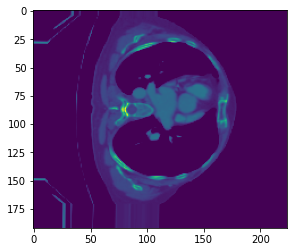

In [18]:
import matplotlib.pyplot as plt

sample_train = train_dataset[9]
plt.imshow(sample_train[0][2][PATCH_SIZE//2])

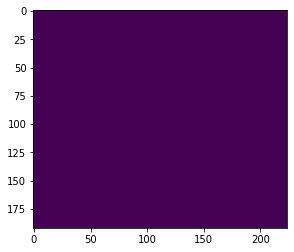

In [19]:
plt.imshow(sample_train[1][PATCH_SIZE//2])

# Dataloader 

In [20]:
import multiprocessing
multiprocessing.cpu_count()

48

In [21]:
from torch.utils.data import DataLoader

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
# NUM_WORKERS = multiprocessing.cpu_count()
NUM_WORKERS = 8

def initTrainDl(train_ds, batch_size = BATCH_SIZE):
    if USE_CUDA:
        batch_size *= torch.cuda.device_count()

    train_dl = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=NUM_WORKERS,
        pin_memory=USE_CUDA,
        shuffle=True,
        drop_last=False # to prevent gradient exploding
    )
    return train_dl

def initValDl(val_ds, batch_size = BATCH_SIZE):
    val_dl = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=NUM_WORKERS,
        pin_memory=USE_CUDA,
    )
    return val_dl

# Set for training

In [22]:
import logging
log = logging.getLogger("3DUnet")
# log.setLevel(logging.WARN)
# log.setLevel(logging.INFO)
log.setLevel(logging.DEBUG)

In [23]:
import datetime
# For logging 
trn_writer = None
val_writer = None
# TB_PREFIX = img_type + "_fn0"
time_str = datetime.datetime.now().strftime('%Y-%m-%d_%H.%M.%S')

In [24]:
# Used for computeClassificationLoss and logMetrics to index into metrics_t/metrics_a
# METRICS_LABEL_NDX = 0
METRICS_LOSS_NDX = 1
# METRICS_FN_LOSS_NDX = 2
# METRICS_ALL_LOSS_NDX = 3

# METRICS_PTP_NDX = 4
# METRICS_PFN_NDX = 5
# METRICS_MFP_NDX = 6
METRICS_TP_NDX = 7
METRICS_FN_NDX = 8
METRICS_FP_NDX = 9

METRICS_SIZE = 10

In [25]:
from torch.optim import SGD, AdamW, RMSprop
from torch import nn
from pytorch3dunet.unet3d.model import ResidualUNet3D, DropResidualUNet3D

def initModel():    
    segmentation_model = DropResidualUNet3D(in_channels=3, out_channels=1, num_groups=FILTER_NUM, f_maps=FILTER_NUM, final_sigmoid=True, testing=True, num_levels=LEVELS)

    # augmentation_model = SegmentationAugmentation(**self.augmentation_dict)

    if USE_CUDA:
        log.info("Using CUDA; {} devices.".format(torch.cuda.device_count()))
        if torch.cuda.device_count() > 1:
            segmentation_model = nn.DataParallel(segmentation_model)
            # augmentation_model = nn.DataParallel(augmentation_model)
        segmentation_model = segmentation_model.to(DEVICE)
        # augmentation_model = augmentation_model.to(DEVICE)

    return segmentation_model #, augmentation_model

def initOptimizer():
    return AdamW(segmentation_model.parameters(), lr=0.0001, weight_decay=0.00002)
    # return SGD(segmentation_model.parameters(), lr=0.001, momentum=0.99)

segmentation_model = initModel()
optimizer = initOptimizer()

# Load model
if MODEL_TO_LOAD :
  model_folder = os.path.join(BASE_DIR, 'models')
  model_path = os.path.join(model_folder, MODEL_TO_LOAD)
  seg_dict = torch.load(model_path, map_location='cpu')
  if torch.cuda.device_count() > 1:
    segmentation_model.module.load_state_dict(seg_dict['model_state'])
  else:
    segmentation_model.load_state_dict(seg_dict['model_state'])
    

In [26]:
segmentation_model

DataParallel(
  (module): DropResidualUNet3D(
    (encoders): ModuleList(
      (0): Encoder(
        (basic_module): DropResNetBlock(
          (conv1): SingleConv(
            (groupnorm): GroupNorm(1, 3, eps=1e-05, affine=True)
            (conv): Conv3d(3, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
            (ReLU): ReLU(inplace=True)
          )
          (conv2): SingleConv(
            (groupnorm): GroupNorm(24, 24, eps=1e-05, affine=True)
            (conv): Conv3d(24, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
            (ReLU): ReLU(inplace=True)
          )
          (conv3): SingleConv(
            (groupnorm): GroupNorm(24, 24, eps=1e-05, affine=True)
            (conv): Conv3d(24, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          )
          (dropout): Dropout(p=0.5, inplace=False)
          (non_linearity): ReLU(inplace=True)
        )
      )
      (1): Encoder(
    

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(segmentation_model)

79594303

In [28]:
from util.util import enumerateWithEstimate

def doTraining(epoch_ndx, train_dl):
    trnMetrics_g = torch.zeros(METRICS_SIZE, len(train_dl.dataset), device=DEVICE)
    segmentation_model.train()
    # train_dl.dataset.shuffleSamples() - 정의에서 처리했음

    batch_iter = enumerateWithEstimate(
        train_dl,
        "E{} Training".format(epoch_ndx),
        start_ndx=train_dl.num_workers,
    )
    for batch_ndx, batch_tup in batch_iter:
        optimizer.zero_grad()

        loss_var = computeBatchLoss(batch_ndx, batch_tup, train_dl.batch_size, trnMetrics_g)
        loss_var.backward()
        
        # Gradient clipping 
        max_norm = 5
        torch.nn.utils.clip_grad_norm_(segmentation_model.parameters(), max_norm)
        optimizer.step()
    global totalTrainingSamples_count
    totalTrainingSamples_count += trnMetrics_g.size(1)

    return trnMetrics_g.to('cpu')

def doValidation(epoch_ndx, val_dl):
    with torch.no_grad():
        valMetrics_g = torch.zeros(METRICS_SIZE, len(val_dl.dataset), device=DEVICE)
        segmentation_model.eval()

        batch_iter = enumerateWithEstimate(
            val_dl,
            "E{} Validation ".format(epoch_ndx),
            start_ndx=val_dl.num_workers,
        )
        for batch_ndx, batch_tup in batch_iter:
            computeBatchLossVal(batch_ndx, batch_tup, val_dl.batch_size, valMetrics_g)

    return valMetrics_g.to('cpu')

def computeBatchLoss(batch_ndx, batch_tup, batch_size, metrics_g,
                      classificationThreshold=0.5):
    input_t, label_t= batch_tup
    
    input_g = input_t.to(DEVICE, non_blocking=True)
    label_g = label_t.to(DEVICE, non_blocking=True)

    # if segmentation_model.training and augmentation_dict:
    #     input_g, label_g = augmentation_model(input_g, label_g)

    prediction_g_multi_ch = segmentation_model(input_g)
    prediction_g = prediction_g_multi_ch[:,0] # B, C, D, H, W -> B, D, H, W
    diceLoss_g = diceLoss(prediction_g, label_g)
    fnLoss_g = diceLoss(prediction_g * label_g, label_g)
    ceLoss = nn.BCELoss()
    ceLoss_g = ceLoss(prediction_g, label_g.float())
    start_ndx = batch_ndx * batch_size
    end_ndx = start_ndx + input_t.size(0)

    with torch.no_grad():
        predictionBool_g = (prediction_g > classificationThreshold).to(torch.float32)

        tp = (     predictionBool_g *  label_g).sum(dim=[1,2,3])
        fn = ((1 - predictionBool_g) *  label_g).sum(dim=[1,2,3])
        fp = (     predictionBool_g * (~label_g)).sum(dim=[1,2,3])

        metrics_g[METRICS_LOSS_NDX, start_ndx:end_ndx] = diceLoss_g
        metrics_g[METRICS_TP_NDX, start_ndx:end_ndx] = tp
        metrics_g[METRICS_FN_NDX, start_ndx:end_ndx] = fn
        metrics_g[METRICS_FP_NDX, start_ndx:end_ndx] = fp

    return diceLoss_g.mean() + ceLoss_g + fnLoss_g.mean() * FN_LOSS 

def computeBatchLossVal(batch_ndx, batch_tup, batch_size, metrics_g,
                      classificationThreshold=0.5):
    input_t, label_t= batch_tup
    
    input_g = input_t.to(DEVICE, non_blocking=True)
    label_g = label_t.to(DEVICE, non_blocking=True)

    prediction_g_multi_ch = segmentation_model(input_g)
    prediction_g = prediction_g_multi_ch[:,0] # B, C, D, H, W -> B, D, H, W
    diceLoss_g = diceLoss(prediction_g, label_g)
    start_ndx = batch_ndx * batch_size
    end_ndx = start_ndx + input_t.size(0)

    with torch.no_grad():
        predictionBool_g = (prediction_g > classificationThreshold).to(torch.float32)

        tp = (     predictionBool_g *  label_g).sum(dim=[1,2,3])
        fn = ((1 - predictionBool_g) *  label_g).sum(dim=[1,2,3])
        fp = (     predictionBool_g * (~label_g)).sum(dim=[1,2,3])

        metrics_g[METRICS_LOSS_NDX, start_ndx:end_ndx] = diceLoss_g
        metrics_g[METRICS_TP_NDX, start_ndx:end_ndx] = tp
        metrics_g[METRICS_FN_NDX, start_ndx:end_ndx] = fn
        metrics_g[METRICS_FP_NDX, start_ndx:end_ndx] = fp

    return diceLoss_g.mean()

def diceLoss(prediction_g, label_g, epsilon=0.00001):
    diceLabel_g = label_g.sum(dim=[1,2,3])
    dicePrediction_g = prediction_g.sum(dim=[1,2,3])
    diceCorrect_g = (prediction_g * label_g).sum(dim=[1,2,3])

    diceRatio_g = (2 * diceCorrect_g + epsilon) \
        / (dicePrediction_g + diceLabel_g + epsilon)

    return 1 - diceRatio_g

In [29]:
from torch.utils.tensorboard import SummaryWriter

def logMetrics(epoch_ndx, mode_str, metrics_t, tb_type = TB_PREFIX):
    log.info("E{} {} {}".format(
        epoch_ndx,
        "Unet",
        tb_type
    ))

    metrics_a = metrics_t.detach().numpy()
    sum_a = metrics_a.sum(axis=1)
    assert np.isfinite(metrics_a).all()

    allLabel_count = sum_a[METRICS_TP_NDX] + sum_a[METRICS_FN_NDX]

    metrics_dict = {}
    metrics_dict['loss/all'] = metrics_a[METRICS_LOSS_NDX].mean()

    metrics_dict['percent_all/tp'] = \
        sum_a[METRICS_TP_NDX] / (allLabel_count or 1) * 100 
    metrics_dict['percent_all/fn'] = \
        sum_a[METRICS_FN_NDX] / (allLabel_count or 1) * 100
    metrics_dict['percent_all/fp'] = \
        sum_a[METRICS_FP_NDX] / (allLabel_count or 1) * 100


    precision = metrics_dict['pr/precision'] = sum_a[METRICS_TP_NDX] \
        / ((sum_a[METRICS_TP_NDX] + sum_a[METRICS_FP_NDX]) or 1)
    recall    = metrics_dict['pr/recall']    = sum_a[METRICS_TP_NDX] \
        / ((sum_a[METRICS_TP_NDX] + sum_a[METRICS_FN_NDX]) or 1)

    metrics_dict['pr/f1_score'] = 2 * (precision * recall) \
        / ((precision + recall) or 1)

    log.info(("E{} {:8} "
              + "{loss/all:.4f} loss, "
              + "{pr/precision:.4f} precision, "
              + "{pr/recall:.4f} recall, "
              + "{pr/f1_score:.4f} f1 score"
              ).format(
        epoch_ndx,
        mode_str,
        **metrics_dict,
    ))
    log.info(("E{} {:8} "
              + "{loss/all:.4f} loss, "
              + "{percent_all/tp:-5.1f}% tp, {percent_all/fn:-5.1f}% fn, {percent_all/fp:-9.1f}% fp"
    ).format(
        epoch_ndx,
        mode_str + '_all',
        **metrics_dict,
    ))
    global trn_writer
    global val_writer
    initTensorboardWriters()
    if mode_str == 'trn':
      writer = trn_writer
    elif mode_str == 'pred':
      writer = pred_writer
    else:
      writer = val_writer

    prefix_str = 'seg_'

    global totalTrainingSamples_count
    for key, value in metrics_dict.items():
        writer.add_scalar(prefix_str + key, value, totalTrainingSamples_count)

    writer.flush()

    score = metrics_dict['pr/recall']

    return score

import os

LOG_DIR = os.path.join(BASE_DIR, 'logs')
if not os.path.exists(LOG_DIR):
  os.mkdir(LOG_DIR)
  
def initTensorboardWriters():
    global trn_writer
    global val_writer
    global pred_writer
    if trn_writer is None:
        trn_writer = SummaryWriter(
            log_dir= os.path.join(LOG_DIR, '{}_trn_seg_{}').format(TB_PREFIX, time_str) )
        val_writer = SummaryWriter(
            log_dir= os.path.join(LOG_DIR, '{}_val_seg_{}').format(TB_PREFIX, time_str) )
#         pred_writer = SummaryWriter(
#             log_dir= os.path.join(LOG_DIR, '{}_pred_seg_{}').format(TB_PREFIX, time_str) )

In [30]:
def saveModel(type_str, epoch_ndx, tb_pre = TB_PREFIX):
    model_name = '{}_model_epoch{}'.format(tb_pre, epoch_ndx)
    file_path = os.path.join(
        BASE_DIR,
        'models',
        model_name
        )

    os.makedirs(os.path.dirname(file_path), mode=0o755, exist_ok=True)

    model = segmentation_model
    if isinstance(model, torch.nn.DataParallel):
        model = model.module

    state = {
        'sys_argv': sys.argv,
        'time': str(datetime.datetime.now()),
        'model_state': model.state_dict(),
        'model_name': type(model).__name__,
        'optimizer_state' : optimizer.state_dict(),
        'optimizer_name': type(optimizer).__name__,
        'epoch': epoch_ndx,
        'totalTrainingSamples_count': totalTrainingSamples_count,
    }
    torch.save(state, file_path)
    log.info(f"Model was saved to {file_path}")
#     remote_location = 's3://{0}'.format(os.path.join(s3bucket, 'result/models', model_name))
#     S3FS.put(file_path, remote_location)
#     log.info("Saved model params to {} and remote S3 bucket".format(file_path))

    with open(file_path, 'rb') as f:
        log.info("SHA1: " + hashlib.sha1(f.read()).hexdigest())

In [31]:
import torch.nn.functional as F

# Pytorch 3D image tensor = Depth, Height, Weight
#w(l-> r), h(t->b), d(u->d) 순서로군

def pad_for_division(image, patch_size):
    patch_d, patch_h, patch_w = patch_size 
    assert patch_d % 32 == 0 & patch_h % 32 == 0 & patch_w % 32 == 0, "Patch size should be divided by 32"
    padding_d = patch_d - image.size(0)%patch_d
    padding_h = patch_h - image.size(1)%patch_h
    padding_w = patch_w - image.size(2)%patch_w
    padded_image = F.pad(image, (0, padding_w, 0, padding_h, 0, padding_d))
    return padded_image 

def pad_for_half(image, patch_size):
    patch_d, patch_h, patch_w = patch_size 
    padded_image = F.pad(image, (patch_w//2, patch_w//2, patch_h//2, patch_h//2, patch_d//2, patch_d//2))
    return padded_image 

    
def adjust_window(image, window):
    width = window[0]
    level = window[1]
    upper = level+width/2
    lower = level-width/2
    copied_image = image.clip(lower, upper)
    copied_image = copied_image-lower
    return (copied_image/(upper-lower))

def convert_to_multi_channel_img(image, windows):
    adjusted_images = [adjust_window(image, window) for window in windows]
    return torch.stack(adjusted_images)

# Process : padding -> adjust windows -> unfold -> neural network -> fold -> crop
#           another padding -> adjust windows -> unfold -> neural network -> fold -> crop 
#           average all by 2 -> compare with the label. 
# 원래는 8개로 해야되는데, 간이 버전이라고 생각해볼 수 있겠음. 

def pred_image_with_model(padded_image, model, batch_size, patch_size):
    '''
    padded_image : image tensor with size of [D, H, W]
    patch_size : tuple with size of 3
    return pred_label : tensor with size of [D, H, W]
    '''
    windows = [(500,200), (700,400), (1200,400)]
    input_channel = padded_image.size(0)
    output_channel = 1
    patch_d, patch_h, patch_w = patch_size 
    total_batch_size = batch_size * torch.cuda.device_count()

    patches = padded_image.unfold(0, patch_d, patch_d).unfold(1, patch_h, patch_h).unfold(2, patch_w, patch_w)
    unfold_shape = patches.size()
    patches = patches.reshape(-1, patch_d, patch_h, patch_w)
    
    processed_patches = torch.zeros_like(patches)
    iter_num = int(np.ceil(patches.size(0)/total_batch_size))
    for i in range(iter_num):
        start = i * total_batch_size
        end = (i+1) * total_batch_size
        batch = patches[start:end]
        batch = convert_to_multi_channel_img(batch, windows)
        batch = batch.permute(1,0,2,3,4)
        proccessed_batch = model(batch).squeeze(1)
        processed_patches[start:end] = proccessed_batch
    
    pred_patches = processed_patches.view(unfold_shape)
    output_d = unfold_shape[0] * unfold_shape[3]
    output_h = unfold_shape[1] * unfold_shape[4]
    output_w = unfold_shape[2] * unfold_shape[5]
    pred_patches = pred_patches.permute(0, 3, 1, 4, 2, 5)
    pred_label = pred_patches.reshape(output_d, output_h, output_w)
    return pred_label

def predict_one_case(image_t, batch_size ,patch_size):
    pad_image = pad_for_division(image_t, patch_size)
    half_pad_image = pad_for_half(pad_image, patch_size)
    d,h,w = image_t.shape
    half_pad_d, half_pad_h, half_pad_w = [size//2 for size in patch_size]
    
    with torch.no_grad():
        segmentation_model.eval()
        pred_label = pred_image_with_model(pad_image, segmentation_model, batch_size, patch_size)
        pred_half_pad_label = pred_image_with_model(half_pad_image, segmentation_model, batch_size, patch_size)
        
    cropped_pred = pred_label[:d, :h, :w]
    cropped_pred_2 = pred_half_pad_label[half_pad_d:half_pad_d+d, half_pad_h:half_pad_h+h, half_pad_w:half_pad_w+w]
    mean_pred = (cropped_pred + cropped_pred_2) / 2
    return mean_pred


def doPrediction(epoch_ndx, files, batch_size, patch_size):
    log.info("E{} Prediction {}".format(epoch_ndx, TB_PREFIX))
    predMetrics_g = torch.zeros(METRICS_SIZE, len(files), device=DEVICE)
    segmentation_model.eval()
    
    for i, file in enumerate(files):
        image = np.load(get_img_path(file))
        image_t = torch.tensor(image)
        label = np.load(get_label_path(file))
        
        pred = predict_one_case(image_t, batch_size, patch_size)
        pred_t = pred > 0.5 # classificationThreshold = 0.5
        label_t = torch.tensor(label)
        
        predictionBool_g = pred_t.unsqueeze(0).to(torch.float32)
        label_g = label_t.unsqueeze(0)
        
        diceLoss_g = diceLoss(predictionBool_g, label_g, epsilon=0.01)
        fnLoss_g = diceLoss(predictionBool_g * label_g, label_g)

        tp = (     predictionBool_g *  label_g).sum(dim=[1,2,3])
        fn = ((1 - predictionBool_g) *  label_g).sum(dim=[1,2,3])
        fp = (     predictionBool_g * (~label_g)).sum(dim=[1,2,3])
        
        predMetrics_g[METRICS_LOSS_NDX, i] = diceLoss_g # 차원 에러날듯 - i로 골라버리면 차원이 하나 줄기 때문.. 확인해봐야함. 
        predMetrics_g[METRICS_TP_NDX, i] = tp
        predMetrics_g[METRICS_FN_NDX, i] = fn
        predMetrics_g[METRICS_FP_NDX, i] = fp
        
    return predMetrics_g.to('cpu')

# Train

In [32]:
log.info("Starting traning...")

train_dl = initTrainDl(train_dataset)
val_dl = initValDl(val_dataset)

best_score = 0.0
validation_cadence = 20
pred_cadence = 20

totalTrainingSamples_count = 0 

2022-11-14 23:41:15,445 INFO     pid:710132 3DUnet:001:<cell line: 1> Starting traning...


In [ ]:
for epoch_ndx in range(1, EPOCHS + 1):
    log.info("Epoch {} of {}, {}/{} batches of size {}*{}".format(
        epoch_ndx,
        EPOCHS,
        len(train_dl),
        len(val_dl),
        BATCH_SIZE,
        (torch.cuda.device_count() if USE_CUDA else 1),
    ))

    trnMetrics_t = doTraining(epoch_ndx, train_dl)

    logMetrics(epoch_ndx, 'trn', trnMetrics_t)

    if epoch_ndx == 1 or epoch_ndx % validation_cadence == 0:
        # if validation is wanted
        valMetrics_t = doValidation(epoch_ndx, val_dl)
        score = logMetrics(epoch_ndx, 'val', valMetrics_t)
        best_score = max(score, best_score)

        # self.saveModel('seg', epoch_ndx, score == best_score)
        saveModel('seg', epoch_ndx)
        # self.logImages(epoch_ndx, 'trn', train_dl)
        # self.logImages(epoch_ndx, 'val', val_dl)

#     if epoch_ndx % pred_cadence ==0:
#         predMetrics_t = doPrediction(epoch_ndx, VAL_FILES, batch_size=1, patch_size=(128,256,256))
#         score = logMetrics(epoch_ndx, 'pred', predMetrics_t)
        
trn_writer.close()
val_writer.close()

2022-11-14 23:42:44,852 INFO     pid:710132 3DUnet:002:<cell line: 1> Epoch 1 of 1500, 78/54 batches of size 1*4
2022-11-14 23:42:44,878 WARNING  pid:710132 util.util:219:enumerateWithEstimate E1 Training ----/78, starting
2022-11-14 23:43:37,208 INFO     pid:710132 util.util:236:enumerateWithEstimate E1 Training   16/78, done at 2022-11-14 23:46:01, 0:02:45
2022-11-14 23:44:14,922 INFO     pid:710132 util.util:236:enumerateWithEstimate E1 Training   32/78, done at 2022-11-14 23:46:01, 0:02:45
2022-11-14 23:45:30,476 INFO     pid:710132 util.util:236:enumerateWithEstimate E1 Training   64/78, done at 2022-11-14 23:46:01, 0:02:45
2022-11-14 23:46:01,294 WARNING  pid:710132 util.util:249:enumerateWithEstimate E1 Training ----/78, done at 2022-11-14 23:46:01
2022-11-14 23:46:01,298 INFO     pid:710132 3DUnet:004:logMetrics E1 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-14 23:46:01,300 INFO     pid:710132 3DUnet:035:logMetrics E1 trn      0.9993 loss, 0.0004 precisi

2022-11-15 00:02:34,183 WARNING  pid:710132 util.util:219:enumerateWithEstimate E7 Training ----/78, starting
2022-11-15 00:03:22,975 INFO     pid:710132 util.util:236:enumerateWithEstimate E7 Training   16/78, done at 2022-11-15 00:05:46, 0:02:44
2022-11-15 00:04:00,803 INFO     pid:710132 util.util:236:enumerateWithEstimate E7 Training   32/78, done at 2022-11-15 00:05:46, 0:02:45
2022-11-15 00:05:16,380 INFO     pid:710132 util.util:236:enumerateWithEstimate E7 Training   64/78, done at 2022-11-15 00:05:47, 0:02:45
2022-11-15 00:05:47,237 WARNING  pid:710132 util.util:249:enumerateWithEstimate E7 Training ----/78, done at 2022-11-15 00:05:47
2022-11-15 00:05:47,242 INFO     pid:710132 3DUnet:004:logMetrics E7 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 00:05:47,244 INFO     pid:710132 3DUnet:035:logMetrics E7 trn      0.9922 loss, 0.0061 precision, 0.0935 recall, 0.0115 f1 score
2022-11-15 00:05:47,245 INFO     pid:710132 3DUnet:045:logMetrics E7 trn_all  

2022-11-15 00:25:51,275 INFO     pid:710132 util.util:236:enumerateWithEstimate E14 Training   16/78, done at 2022-11-15 00:28:15, 0:02:45
2022-11-15 00:26:29,017 INFO     pid:710132 util.util:236:enumerateWithEstimate E14 Training   32/78, done at 2022-11-15 00:28:15, 0:02:45
2022-11-15 00:27:44,792 INFO     pid:710132 util.util:236:enumerateWithEstimate E14 Training   64/78, done at 2022-11-15 00:28:15, 0:02:45
2022-11-15 00:28:15,551 WARNING  pid:710132 util.util:249:enumerateWithEstimate E14 Training ----/78, done at 2022-11-15 00:28:15
2022-11-15 00:28:15,555 INFO     pid:710132 3DUnet:004:logMetrics E14 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 00:28:15,556 INFO     pid:710132 3DUnet:035:logMetrics E14 trn      0.9797 loss, 0.0122 precision, 0.1747 recall, 0.0227 f1 score
2022-11-15 00:28:15,557 INFO     pid:710132 3DUnet:045:logMetrics E14 trn_all  0.9797 loss,  17.5% tp,  82.5% fn,    1420.2% fp
2022-11-15 00:28:15,560 INFO     pid:710132 3DUnet:002

2022-11-15 00:47:45,947 INFO     pid:710132 util.util:236:enumerateWithEstimate E20 Validation    32/54, done at 2022-11-15 00:47:55, 0:00:21
2022-11-15 00:47:55,955 WARNING  pid:710132 util.util:249:enumerateWithEstimate E20 Validation  ----/54, done at 2022-11-15 00:47:55
2022-11-15 00:47:57,127 INFO     pid:710132 3DUnet:004:logMetrics E20 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 00:47:57,128 INFO     pid:710132 3DUnet:035:logMetrics E20 val      0.9521 loss, 0.0278 precision, 0.2827 recall, 0.0507 f1 score
2022-11-15 00:47:57,129 INFO     pid:710132 3DUnet:045:logMetrics E20 val_all  0.9521 loss,  28.3% tp,  71.7% fn,     987.5% fp
2022-11-15 00:47:58,734 INFO     pid:710132 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_192+/models/bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24_model_epoch20
2022-11-15 00:48:00,423 INFO     pid:710132 3DUnet:032:saveModel SHA1: a375e9aa627fd5b66191dcc6066457a5d7d25cb0
2022-11-15 00:48:00,425 INFO 

2022-11-15 01:08:03,460 INFO     pid:710132 util.util:236:enumerateWithEstimate E27 Training   16/78, done at 2022-11-15 01:10:27, 0:02:45
2022-11-15 01:08:41,261 INFO     pid:710132 util.util:236:enumerateWithEstimate E27 Training   32/78, done at 2022-11-15 01:10:27, 0:02:45
2022-11-15 01:09:56,757 INFO     pid:710132 util.util:236:enumerateWithEstimate E27 Training   64/78, done at 2022-11-15 01:10:27, 0:02:45
2022-11-15 01:10:27,728 WARNING  pid:710132 util.util:249:enumerateWithEstimate E27 Training ----/78, done at 2022-11-15 01:10:27
2022-11-15 01:10:27,734 INFO     pid:710132 3DUnet:004:logMetrics E27 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 01:10:27,736 INFO     pid:710132 3DUnet:035:logMetrics E27 trn      0.9587 loss, 0.0284 precision, 0.1515 recall, 0.0478 f1 score
2022-11-15 01:10:27,738 INFO     pid:710132 3DUnet:045:logMetrics E27 trn_all  0.9587 loss,  15.1% tp,  84.9% fn,     518.3% fp
2022-11-15 01:10:27,742 INFO     pid:710132 3DUnet:002

2022-11-15 01:30:30,361 INFO     pid:710132 util.util:236:enumerateWithEstimate E34 Training   16/78, done at 2022-11-15 01:32:54, 0:02:44
2022-11-15 01:31:08,113 INFO     pid:710132 util.util:236:enumerateWithEstimate E34 Training   32/78, done at 2022-11-15 01:32:54, 0:02:45
2022-11-15 01:32:23,479 INFO     pid:710132 util.util:236:enumerateWithEstimate E34 Training   64/78, done at 2022-11-15 01:32:54, 0:02:44
2022-11-15 01:32:54,286 WARNING  pid:710132 util.util:249:enumerateWithEstimate E34 Training ----/78, done at 2022-11-15 01:32:54
2022-11-15 01:32:54,289 INFO     pid:710132 3DUnet:004:logMetrics E34 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 01:32:54,291 INFO     pid:710132 3DUnet:035:logMetrics E34 trn      0.9416 loss, 0.0433 precision, 0.1290 recall, 0.0648 f1 score
2022-11-15 01:32:54,291 INFO     pid:710132 3DUnet:045:logMetrics E34 trn_all  0.9416 loss,  12.9% tp,  87.1% fn,     285.1% fp
2022-11-15 01:32:54,294 INFO     pid:710132 3DUnet:002

2022-11-15 01:52:27,977 INFO     pid:710132 util.util:236:enumerateWithEstimate E40 Validation    32/54, done at 2022-11-15 01:52:37, 0:00:21
2022-11-15 01:52:37,956 WARNING  pid:710132 util.util:249:enumerateWithEstimate E40 Validation  ----/54, done at 2022-11-15 01:52:37
2022-11-15 01:52:39,147 INFO     pid:710132 3DUnet:004:logMetrics E40 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 01:52:39,152 INFO     pid:710132 3DUnet:035:logMetrics E40 val      0.8955 loss, 0.0849 precision, 0.1774 recall, 0.1148 f1 score
2022-11-15 01:52:39,156 INFO     pid:710132 3DUnet:045:logMetrics E40 val_all  0.8955 loss,  17.7% tp,  82.3% fn,     191.3% fp
2022-11-15 01:52:41,690 INFO     pid:710132 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_192+/models/bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24_model_epoch40
2022-11-15 01:52:43,406 INFO     pid:710132 3DUnet:032:saveModel SHA1: 242c11700b4ff72f7fc13933e73ff24bcefc6096
2022-11-15 01:52:43,408 INFO 

2022-11-15 02:12:46,792 INFO     pid:710132 util.util:236:enumerateWithEstimate E47 Training   16/78, done at 2022-11-15 02:15:10, 0:02:45
2022-11-15 02:13:24,567 INFO     pid:710132 util.util:236:enumerateWithEstimate E47 Training   32/78, done at 2022-11-15 02:15:10, 0:02:45
2022-11-15 02:14:39,927 INFO     pid:710132 util.util:236:enumerateWithEstimate E47 Training   64/78, done at 2022-11-15 02:15:10, 0:02:45
2022-11-15 02:15:10,775 WARNING  pid:710132 util.util:249:enumerateWithEstimate E47 Training ----/78, done at 2022-11-15 02:15:10
2022-11-15 02:15:10,785 INFO     pid:710132 3DUnet:004:logMetrics E47 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 02:15:10,790 INFO     pid:710132 3DUnet:035:logMetrics E47 trn      0.9248 loss, 0.0740 precision, 0.1036 recall, 0.0863 f1 score
2022-11-15 02:15:10,793 INFO     pid:710132 3DUnet:045:logMetrics E47 trn_all  0.9248 loss,  10.4% tp,  89.6% fn,     129.7% fp
2022-11-15 02:15:10,808 INFO     pid:710132 3DUnet:002

2022-11-15 02:35:14,472 INFO     pid:710132 util.util:236:enumerateWithEstimate E54 Training   16/78, done at 2022-11-15 02:37:38, 0:02:45
2022-11-15 02:35:52,180 INFO     pid:710132 util.util:236:enumerateWithEstimate E54 Training   32/78, done at 2022-11-15 02:37:38, 0:02:45
2022-11-15 02:37:07,746 INFO     pid:710132 util.util:236:enumerateWithEstimate E54 Training   64/78, done at 2022-11-15 02:37:38, 0:02:45
2022-11-15 02:37:38,474 WARNING  pid:710132 util.util:249:enumerateWithEstimate E54 Training ----/78, done at 2022-11-15 02:37:38
2022-11-15 02:37:38,479 INFO     pid:710132 3DUnet:004:logMetrics E54 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 02:37:38,481 INFO     pid:710132 3DUnet:035:logMetrics E54 trn      0.9165 loss, 0.1029 precision, 0.1002 recall, 0.1015 f1 score
2022-11-15 02:37:38,482 INFO     pid:710132 3DUnet:045:logMetrics E54 trn_all  0.9165 loss,  10.0% tp,  90.0% fn,      87.4% fp
2022-11-15 02:37:38,487 INFO     pid:710132 3DUnet:002

2022-11-15 02:57:08,805 INFO     pid:710132 util.util:236:enumerateWithEstimate E60 Validation    32/54, done at 2022-11-15 02:57:18, 0:00:21
2022-11-15 02:57:18,804 WARNING  pid:710132 util.util:249:enumerateWithEstimate E60 Validation  ----/54, done at 2022-11-15 02:57:18
2022-11-15 02:57:19,981 INFO     pid:710132 3DUnet:004:logMetrics E60 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 02:57:19,985 INFO     pid:710132 3DUnet:035:logMetrics E60 val      0.8951 loss, 0.0782 precision, 0.2006 recall, 0.1125 f1 score
2022-11-15 02:57:19,989 INFO     pid:710132 3DUnet:045:logMetrics E60 val_all  0.8951 loss,  20.1% tp,  79.9% fn,     236.6% fp
2022-11-15 02:57:22,302 INFO     pid:710132 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_192+/models/bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24_model_epoch60
2022-11-15 02:57:23,982 INFO     pid:710132 3DUnet:032:saveModel SHA1: 6b80d54380e3a1fcdc8a047a29cfb68a4fee3d80
2022-11-15 02:57:23,984 INFO 

2022-11-15 03:17:30,362 INFO     pid:710132 util.util:236:enumerateWithEstimate E67 Training   16/78, done at 2022-11-15 03:19:54, 0:02:45
2022-11-15 03:18:08,264 INFO     pid:710132 util.util:236:enumerateWithEstimate E67 Training   32/78, done at 2022-11-15 03:19:54, 0:02:45
2022-11-15 03:19:23,664 INFO     pid:710132 util.util:236:enumerateWithEstimate E67 Training   64/78, done at 2022-11-15 03:19:54, 0:02:45
2022-11-15 03:19:54,639 WARNING  pid:710132 util.util:249:enumerateWithEstimate E67 Training ----/78, done at 2022-11-15 03:19:54
2022-11-15 03:19:54,642 INFO     pid:710132 3DUnet:004:logMetrics E67 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 03:19:54,643 INFO     pid:710132 3DUnet:035:logMetrics E67 trn      0.9087 loss, 0.1112 precision, 0.1102 recall, 0.1107 f1 score
2022-11-15 03:19:54,644 INFO     pid:710132 3DUnet:045:logMetrics E67 trn_all  0.9087 loss,  11.0% tp,  89.0% fn,      88.1% fp
2022-11-15 03:19:54,647 INFO     pid:710132 3DUnet:002

2022-11-15 03:39:57,288 INFO     pid:710132 util.util:236:enumerateWithEstimate E74 Training   16/78, done at 2022-11-15 03:42:21, 0:02:45
2022-11-15 03:40:35,050 INFO     pid:710132 util.util:236:enumerateWithEstimate E74 Training   32/78, done at 2022-11-15 03:42:21, 0:02:45
2022-11-15 03:41:50,485 INFO     pid:710132 util.util:236:enumerateWithEstimate E74 Training   64/78, done at 2022-11-15 03:42:21, 0:02:45
2022-11-15 03:42:21,273 WARNING  pid:710132 util.util:249:enumerateWithEstimate E74 Training ----/78, done at 2022-11-15 03:42:21
2022-11-15 03:42:21,276 INFO     pid:710132 3DUnet:004:logMetrics E74 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 03:42:21,278 INFO     pid:710132 3DUnet:035:logMetrics E74 trn      0.9077 loss, 0.1088 precision, 0.1192 recall, 0.1138 f1 score
2022-11-15 03:42:21,278 INFO     pid:710132 3DUnet:045:logMetrics E74 trn_all  0.9077 loss,  11.9% tp,  88.1% fn,      97.7% fp
2022-11-15 03:42:21,283 INFO     pid:710132 3DUnet:002

2022-11-15 04:01:50,245 INFO     pid:710132 util.util:236:enumerateWithEstimate E80 Validation    32/54, done at 2022-11-15 04:02:00, 0:00:21
2022-11-15 04:02:00,329 WARNING  pid:710132 util.util:249:enumerateWithEstimate E80 Validation  ----/54, done at 2022-11-15 04:02:00
2022-11-15 04:02:01,523 INFO     pid:710132 3DUnet:004:logMetrics E80 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 04:02:01,524 INFO     pid:710132 3DUnet:035:logMetrics E80 val      0.9042 loss, 0.1408 precision, 0.1157 recall, 0.1270 f1 score
2022-11-15 04:02:01,525 INFO     pid:710132 3DUnet:045:logMetrics E80 val_all  0.9042 loss,  11.6% tp,  88.4% fn,      70.6% fp
2022-11-15 04:02:03,124 INFO     pid:710132 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_192+/models/bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24_model_epoch80
2022-11-15 04:02:04,799 INFO     pid:710132 3DUnet:032:saveModel SHA1: 911f1b678aa34b79ddec913d7748e39353bcce57
2022-11-15 04:02:04,802 INFO 

2022-11-15 04:22:09,986 INFO     pid:710132 util.util:236:enumerateWithEstimate E87 Training   16/78, done at 2022-11-15 04:24:33, 0:02:44
2022-11-15 04:22:47,820 INFO     pid:710132 util.util:236:enumerateWithEstimate E87 Training   32/78, done at 2022-11-15 04:24:34, 0:02:45
2022-11-15 04:24:03,325 INFO     pid:710132 util.util:236:enumerateWithEstimate E87 Training   64/78, done at 2022-11-15 04:24:34, 0:02:45
2022-11-15 04:24:34,232 WARNING  pid:710132 util.util:249:enumerateWithEstimate E87 Training ----/78, done at 2022-11-15 04:24:34
2022-11-15 04:24:34,235 INFO     pid:710132 3DUnet:004:logMetrics E87 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 04:24:34,236 INFO     pid:710132 3DUnet:035:logMetrics E87 trn      0.9057 loss, 0.1181 precision, 0.1081 recall, 0.1129 f1 score
2022-11-15 04:24:34,237 INFO     pid:710132 3DUnet:045:logMetrics E87 trn_all  0.9057 loss,  10.8% tp,  89.2% fn,      80.7% fp
2022-11-15 04:24:34,240 INFO     pid:710132 3DUnet:002

2022-11-15 04:44:38,950 INFO     pid:710132 util.util:236:enumerateWithEstimate E94 Training   16/78, done at 2022-11-15 04:47:02, 0:02:44
2022-11-15 04:45:16,727 INFO     pid:710132 util.util:236:enumerateWithEstimate E94 Training   32/78, done at 2022-11-15 04:47:02, 0:02:45
2022-11-15 04:46:32,150 INFO     pid:710132 util.util:236:enumerateWithEstimate E94 Training   64/78, done at 2022-11-15 04:47:02, 0:02:45
2022-11-15 04:47:03,012 WARNING  pid:710132 util.util:249:enumerateWithEstimate E94 Training ----/78, done at 2022-11-15 04:47:03
2022-11-15 04:47:03,016 INFO     pid:710132 3DUnet:004:logMetrics E94 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 04:47:03,018 INFO     pid:710132 3DUnet:035:logMetrics E94 trn      0.8965 loss, 0.1334 precision, 0.1187 recall, 0.1257 f1 score
2022-11-15 04:47:03,019 INFO     pid:710132 3DUnet:045:logMetrics E94 trn_all  0.8965 loss,  11.9% tp,  88.1% fn,      77.1% fp
2022-11-15 04:47:03,023 INFO     pid:710132 3DUnet:002

2022-11-15 05:06:34,016 INFO     pid:710132 util.util:236:enumerateWithEstimate E100 Validation    32/54, done at 2022-11-15 05:06:43, 0:00:21
2022-11-15 05:06:44,023 WARNING  pid:710132 util.util:249:enumerateWithEstimate E100 Validation  ----/54, done at 2022-11-15 05:06:44
2022-11-15 05:06:45,187 INFO     pid:710132 3DUnet:004:logMetrics E100 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 05:06:45,189 INFO     pid:710132 3DUnet:035:logMetrics E100 val      0.8833 loss, 0.1197 precision, 0.1468 recall, 0.1319 f1 score
2022-11-15 05:06:45,190 INFO     pid:710132 3DUnet:045:logMetrics E100 val_all  0.8833 loss,  14.7% tp,  85.3% fn,     107.9% fp
2022-11-15 05:06:46,816 INFO     pid:710132 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_192+/models/bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24_model_epoch100
2022-11-15 05:06:48,515 INFO     pid:710132 3DUnet:032:saveModel SHA1: ad81d2b279eadbd0da1a1058698d31dfa05fb06e
2022-11-15 05:06:48,518

2022-11-15 05:26:55,934 INFO     pid:710132 util.util:236:enumerateWithEstimate E107 Training   16/78, done at 2022-11-15 05:29:19, 0:02:44
2022-11-15 05:27:33,681 INFO     pid:710132 util.util:236:enumerateWithEstimate E107 Training   32/78, done at 2022-11-15 05:29:19, 0:02:44
2022-11-15 05:28:49,078 INFO     pid:710132 util.util:236:enumerateWithEstimate E107 Training   64/78, done at 2022-11-15 05:29:19, 0:02:44
2022-11-15 05:29:19,910 WARNING  pid:710132 util.util:249:enumerateWithEstimate E107 Training ----/78, done at 2022-11-15 05:29:19
2022-11-15 05:29:19,914 INFO     pid:710132 3DUnet:004:logMetrics E107 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 05:29:19,916 INFO     pid:710132 3DUnet:035:logMetrics E107 trn      0.8922 loss, 0.1363 precision, 0.1160 recall, 0.1253 f1 score
2022-11-15 05:29:19,917 INFO     pid:710132 3DUnet:045:logMetrics E107 trn_all  0.8922 loss,  11.6% tp,  88.4% fn,      73.5% fp
2022-11-15 05:29:19,922 INFO     pid:710132 3DU

2022-11-15 05:49:24,127 INFO     pid:710132 util.util:236:enumerateWithEstimate E114 Training   16/78, done at 2022-11-15 05:51:48, 0:02:45
2022-11-15 05:50:01,754 INFO     pid:710132 util.util:236:enumerateWithEstimate E114 Training   32/78, done at 2022-11-15 05:51:47, 0:02:44
2022-11-15 05:51:17,321 INFO     pid:710132 util.util:236:enumerateWithEstimate E114 Training   64/78, done at 2022-11-15 05:51:47, 0:02:45
2022-11-15 05:51:48,101 WARNING  pid:710132 util.util:249:enumerateWithEstimate E114 Training ----/78, done at 2022-11-15 05:51:48
2022-11-15 05:51:48,106 INFO     pid:710132 3DUnet:004:logMetrics E114 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 05:51:48,108 INFO     pid:710132 3DUnet:035:logMetrics E114 trn      0.8861 loss, 0.1661 precision, 0.1140 recall, 0.1352 f1 score
2022-11-15 05:51:48,110 INFO     pid:710132 3DUnet:045:logMetrics E114 trn_all  0.8861 loss,  11.4% tp,  88.6% fn,      57.3% fp
2022-11-15 05:51:48,114 INFO     pid:710132 3DU

2022-11-15 06:11:18,743 INFO     pid:710132 util.util:236:enumerateWithEstimate E120 Validation    32/54, done at 2022-11-15 06:11:28, 0:00:21
2022-11-15 06:11:28,761 WARNING  pid:710132 util.util:249:enumerateWithEstimate E120 Validation  ----/54, done at 2022-11-15 06:11:28
2022-11-15 06:11:29,922 INFO     pid:710132 3DUnet:004:logMetrics E120 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 06:11:29,924 INFO     pid:710132 3DUnet:035:logMetrics E120 val      0.8570 loss, 0.1619 precision, 0.1646 recall, 0.1632 f1 score
2022-11-15 06:11:29,925 INFO     pid:710132 3DUnet:045:logMetrics E120 val_all  0.8570 loss,  16.5% tp,  83.5% fn,      85.2% fp
2022-11-15 06:11:31,545 INFO     pid:710132 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_192+/models/bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24_model_epoch120
2022-11-15 06:11:33,238 INFO     pid:710132 3DUnet:032:saveModel SHA1: b4e693308d353d9fba66815db60b69b185e8c1b5
2022-11-15 06:11:33,241

2022-11-15 06:31:36,220 INFO     pid:710132 util.util:236:enumerateWithEstimate E127 Training   16/78, done at 2022-11-15 06:33:59, 0:02:44
2022-11-15 06:32:14,012 INFO     pid:710132 util.util:236:enumerateWithEstimate E127 Training   32/78, done at 2022-11-15 06:34:00, 0:02:45
2022-11-15 06:33:29,462 INFO     pid:710132 util.util:236:enumerateWithEstimate E127 Training   64/78, done at 2022-11-15 06:34:00, 0:02:45
2022-11-15 06:34:00,283 WARNING  pid:710132 util.util:249:enumerateWithEstimate E127 Training ----/78, done at 2022-11-15 06:34:00
2022-11-15 06:34:00,286 INFO     pid:710132 3DUnet:004:logMetrics E127 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 06:34:00,288 INFO     pid:710132 3DUnet:035:logMetrics E127 trn      0.8864 loss, 0.1686 precision, 0.1251 recall, 0.1436 f1 score
2022-11-15 06:34:00,289 INFO     pid:710132 3DUnet:045:logMetrics E127 trn_all  0.8864 loss,  12.5% tp,  87.5% fn,      61.7% fp
2022-11-15 06:34:00,292 INFO     pid:710132 3DU

2022-11-15 06:54:04,246 INFO     pid:710132 util.util:236:enumerateWithEstimate E134 Training   16/78, done at 2022-11-15 06:56:28, 0:02:45
2022-11-15 06:54:42,036 INFO     pid:710132 util.util:236:enumerateWithEstimate E134 Training   32/78, done at 2022-11-15 06:56:28, 0:02:45
2022-11-15 06:55:57,514 INFO     pid:710132 util.util:236:enumerateWithEstimate E134 Training   64/78, done at 2022-11-15 06:56:28, 0:02:45
2022-11-15 06:56:28,342 WARNING  pid:710132 util.util:249:enumerateWithEstimate E134 Training ----/78, done at 2022-11-15 06:56:28
2022-11-15 06:56:28,353 INFO     pid:710132 3DUnet:004:logMetrics E134 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 06:56:28,357 INFO     pid:710132 3DUnet:035:logMetrics E134 trn      0.8822 loss, 0.1386 precision, 0.1312 recall, 0.1348 f1 score
2022-11-15 06:56:28,359 INFO     pid:710132 3DUnet:045:logMetrics E134 trn_all  0.8822 loss,  13.1% tp,  86.9% fn,      81.6% fp
2022-11-15 06:56:28,368 INFO     pid:710132 3DU

2022-11-15 07:15:57,409 INFO     pid:710132 util.util:236:enumerateWithEstimate E140 Validation    32/54, done at 2022-11-15 07:16:07, 0:00:21
2022-11-15 07:16:07,418 WARNING  pid:710132 util.util:249:enumerateWithEstimate E140 Validation  ----/54, done at 2022-11-15 07:16:07
2022-11-15 07:16:08,594 INFO     pid:710132 3DUnet:004:logMetrics E140 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 07:16:08,596 INFO     pid:710132 3DUnet:035:logMetrics E140 val      0.8927 loss, 0.1678 precision, 0.1048 recall, 0.1290 f1 score
2022-11-15 07:16:08,597 INFO     pid:710132 3DUnet:045:logMetrics E140 val_all  0.8927 loss,  10.5% tp,  89.5% fn,      52.0% fp
2022-11-15 07:16:10,198 INFO     pid:710132 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_192+/models/bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24_model_epoch140
2022-11-15 07:16:11,865 INFO     pid:710132 3DUnet:032:saveModel SHA1: 25b1094bd0bc4ced64e6890c3910ea467f7e6381
2022-11-15 07:16:11,866

2022-11-15 07:36:17,378 INFO     pid:710132 util.util:236:enumerateWithEstimate E147 Training   16/78, done at 2022-11-15 07:38:41, 0:02:44
2022-11-15 07:36:55,097 INFO     pid:710132 util.util:236:enumerateWithEstimate E147 Training   32/78, done at 2022-11-15 07:38:41, 0:02:45
2022-11-15 07:38:10,489 INFO     pid:710132 util.util:236:enumerateWithEstimate E147 Training   64/78, done at 2022-11-15 07:38:41, 0:02:44
2022-11-15 07:38:41,359 WARNING  pid:710132 util.util:249:enumerateWithEstimate E147 Training ----/78, done at 2022-11-15 07:38:41
2022-11-15 07:38:41,363 INFO     pid:710132 3DUnet:004:logMetrics E147 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 07:38:41,365 INFO     pid:710132 3DUnet:035:logMetrics E147 trn      0.8754 loss, 0.1798 precision, 0.1353 recall, 0.1544 f1 score
2022-11-15 07:38:41,366 INFO     pid:710132 3DUnet:045:logMetrics E147 trn_all  0.8754 loss,  13.5% tp,  86.5% fn,      61.7% fp
2022-11-15 07:38:41,371 INFO     pid:710132 3DU

2022-11-15 07:58:42,606 INFO     pid:710132 util.util:236:enumerateWithEstimate E154 Training   16/78, done at 2022-11-15 08:01:05, 0:02:44
2022-11-15 07:59:20,527 INFO     pid:710132 util.util:236:enumerateWithEstimate E154 Training   32/78, done at 2022-11-15 08:01:06, 0:02:45
2022-11-15 08:00:35,880 INFO     pid:710132 util.util:236:enumerateWithEstimate E154 Training   64/78, done at 2022-11-15 08:01:06, 0:02:45
2022-11-15 08:01:06,718 WARNING  pid:710132 util.util:249:enumerateWithEstimate E154 Training ----/78, done at 2022-11-15 08:01:06
2022-11-15 08:01:06,722 INFO     pid:710132 3DUnet:004:logMetrics E154 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 08:01:06,723 INFO     pid:710132 3DUnet:035:logMetrics E154 trn      0.8806 loss, 0.1536 precision, 0.1399 recall, 0.1464 f1 score
2022-11-15 08:01:06,724 INFO     pid:710132 3DUnet:045:logMetrics E154 trn_all  0.8806 loss,  14.0% tp,  86.0% fn,      77.0% fp
2022-11-15 08:01:06,726 INFO     pid:710132 3DU

2022-11-15 08:20:37,400 INFO     pid:710132 util.util:236:enumerateWithEstimate E160 Validation    32/54, done at 2022-11-15 08:20:47, 0:00:21
2022-11-15 08:20:47,432 WARNING  pid:710132 util.util:249:enumerateWithEstimate E160 Validation  ----/54, done at 2022-11-15 08:20:47
2022-11-15 08:20:48,585 INFO     pid:710132 3DUnet:004:logMetrics E160 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 08:20:48,592 INFO     pid:710132 3DUnet:035:logMetrics E160 val      0.8768 loss, 0.1613 precision, 0.1421 recall, 0.1511 f1 score
2022-11-15 08:20:48,598 INFO     pid:710132 3DUnet:045:logMetrics E160 val_all  0.8768 loss,  14.2% tp,  85.8% fn,      73.9% fp
2022-11-15 08:20:52,058 INFO     pid:710132 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_192+/models/bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24_model_epoch160
2022-11-15 08:20:53,762 INFO     pid:710132 3DUnet:032:saveModel SHA1: a745d3cc5933509d4c23cf9704ea8ac793329f18
2022-11-15 08:20:53,765

2022-11-15 08:40:56,995 INFO     pid:710132 util.util:236:enumerateWithEstimate E167 Training   16/78, done at 2022-11-15 08:43:21, 0:02:45
2022-11-15 08:41:34,670 INFO     pid:710132 util.util:236:enumerateWithEstimate E167 Training   32/78, done at 2022-11-15 08:43:20, 0:02:44
2022-11-15 08:42:50,087 INFO     pid:710132 util.util:236:enumerateWithEstimate E167 Training   64/78, done at 2022-11-15 08:43:20, 0:02:44
2022-11-15 08:43:20,895 WARNING  pid:710132 util.util:249:enumerateWithEstimate E167 Training ----/78, done at 2022-11-15 08:43:20
2022-11-15 08:43:20,898 INFO     pid:710132 3DUnet:004:logMetrics E167 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 08:43:20,900 INFO     pid:710132 3DUnet:035:logMetrics E167 trn      0.8686 loss, 0.1711 precision, 0.1463 recall, 0.1577 f1 score
2022-11-15 08:43:20,900 INFO     pid:710132 3DUnet:045:logMetrics E167 trn_all  0.8686 loss,  14.6% tp,  85.4% fn,      70.9% fp
2022-11-15 08:43:20,904 INFO     pid:710132 3DU

2022-11-15 09:03:26,249 INFO     pid:710132 util.util:236:enumerateWithEstimate E174 Training   16/78, done at 2022-11-15 09:05:49, 0:02:44
2022-11-15 09:04:03,930 INFO     pid:710132 util.util:236:enumerateWithEstimate E174 Training   32/78, done at 2022-11-15 09:05:49, 0:02:44
2022-11-15 09:05:19,469 INFO     pid:710132 util.util:236:enumerateWithEstimate E174 Training   64/78, done at 2022-11-15 09:05:50, 0:02:45
2022-11-15 09:05:50,253 WARNING  pid:710132 util.util:249:enumerateWithEstimate E174 Training ----/78, done at 2022-11-15 09:05:50
2022-11-15 09:05:50,256 INFO     pid:710132 3DUnet:004:logMetrics E174 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 09:05:50,257 INFO     pid:710132 3DUnet:035:logMetrics E174 trn      0.8645 loss, 0.1793 precision, 0.1601 recall, 0.1692 f1 score
2022-11-15 09:05:50,258 INFO     pid:710132 3DUnet:045:logMetrics E174 trn_all  0.8645 loss,  16.0% tp,  84.0% fn,      73.3% fp
2022-11-15 09:05:50,262 INFO     pid:710132 3DU

2022-11-15 09:25:23,346 INFO     pid:710132 util.util:236:enumerateWithEstimate E180 Validation    32/54, done at 2022-11-15 09:25:33, 0:00:21
2022-11-15 09:25:33,358 WARNING  pid:710132 util.util:249:enumerateWithEstimate E180 Validation  ----/54, done at 2022-11-15 09:25:33
2022-11-15 09:25:34,520 INFO     pid:710132 3DUnet:004:logMetrics E180 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 09:25:34,522 INFO     pid:710132 3DUnet:035:logMetrics E180 val      0.8651 loss, 0.1440 precision, 0.1620 recall, 0.1524 f1 score
2022-11-15 09:25:34,523 INFO     pid:710132 3DUnet:045:logMetrics E180 val_all  0.8651 loss,  16.2% tp,  83.8% fn,      96.3% fp
2022-11-15 09:25:36,176 INFO     pid:710132 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_192+/models/bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24_model_epoch180
2022-11-15 09:25:37,870 INFO     pid:710132 3DUnet:032:saveModel SHA1: 90c6838a2fb963d838c1fe6a5a631bf863bb1186
2022-11-15 09:25:37,872

2022-11-15 09:45:44,151 INFO     pid:710132 util.util:236:enumerateWithEstimate E187 Training   16/78, done at 2022-11-15 09:48:07, 0:02:44
2022-11-15 09:46:21,987 INFO     pid:710132 util.util:236:enumerateWithEstimate E187 Training   32/78, done at 2022-11-15 09:48:08, 0:02:45
2022-11-15 09:47:37,459 INFO     pid:710132 util.util:236:enumerateWithEstimate E187 Training   64/78, done at 2022-11-15 09:48:08, 0:02:45
2022-11-15 09:48:08,338 WARNING  pid:710132 util.util:249:enumerateWithEstimate E187 Training ----/78, done at 2022-11-15 09:48:08
2022-11-15 09:48:08,343 INFO     pid:710132 3DUnet:004:logMetrics E187 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 09:48:08,345 INFO     pid:710132 3DUnet:035:logMetrics E187 trn      0.8585 loss, 0.1857 precision, 0.1493 recall, 0.1655 f1 score
2022-11-15 09:48:08,347 INFO     pid:710132 3DUnet:045:logMetrics E187 trn_all  0.8585 loss,  14.9% tp,  85.1% fn,      65.5% fp
2022-11-15 09:48:08,351 INFO     pid:710132 3DU

2022-11-15 10:08:12,173 INFO     pid:710132 util.util:236:enumerateWithEstimate E194 Training   16/78, done at 2022-11-15 10:10:35, 0:02:44
2022-11-15 10:08:49,893 INFO     pid:710132 util.util:236:enumerateWithEstimate E194 Training   32/78, done at 2022-11-15 10:10:35, 0:02:44
2022-11-15 10:10:05,436 INFO     pid:710132 util.util:236:enumerateWithEstimate E194 Training   64/78, done at 2022-11-15 10:10:36, 0:02:45
2022-11-15 10:10:36,282 WARNING  pid:710132 util.util:249:enumerateWithEstimate E194 Training ----/78, done at 2022-11-15 10:10:36
2022-11-15 10:10:36,286 INFO     pid:710132 3DUnet:004:logMetrics E194 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 10:10:36,287 INFO     pid:710132 3DUnet:035:logMetrics E194 trn      0.8587 loss, 0.2192 precision, 0.1443 recall, 0.1740 f1 score
2022-11-15 10:10:36,288 INFO     pid:710132 3DUnet:045:logMetrics E194 trn_all  0.8587 loss,  14.4% tp,  85.6% fn,      51.4% fp
2022-11-15 10:10:36,292 INFO     pid:710132 3DU

2022-11-15 10:30:08,114 INFO     pid:710132 util.util:236:enumerateWithEstimate E200 Validation    32/54, done at 2022-11-15 10:30:17, 0:00:21
2022-11-15 10:30:18,134 WARNING  pid:710132 util.util:249:enumerateWithEstimate E200 Validation  ----/54, done at 2022-11-15 10:30:18
2022-11-15 10:30:19,297 INFO     pid:710132 3DUnet:004:logMetrics E200 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 10:30:19,298 INFO     pid:710132 3DUnet:035:logMetrics E200 val      0.8637 loss, 0.2154 precision, 0.1336 recall, 0.1649 f1 score
2022-11-15 10:30:19,299 INFO     pid:710132 3DUnet:045:logMetrics E200 val_all  0.8637 loss,  13.4% tp,  86.6% fn,      48.7% fp
2022-11-15 10:30:20,913 INFO     pid:710132 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_192+/models/bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24_model_epoch200
2022-11-15 10:30:22,620 INFO     pid:710132 3DUnet:032:saveModel SHA1: 9f949b08a2b341a975ed1eea46095c5ba0741c5c
2022-11-15 10:30:22,621

2022-11-15 10:50:26,739 INFO     pid:710132 util.util:236:enumerateWithEstimate E207 Training   16/78, done at 2022-11-15 10:52:50, 0:02:44
2022-11-15 10:51:04,466 INFO     pid:710132 util.util:236:enumerateWithEstimate E207 Training   32/78, done at 2022-11-15 10:52:50, 0:02:44
2022-11-15 10:52:20,051 INFO     pid:710132 util.util:236:enumerateWithEstimate E207 Training   64/78, done at 2022-11-15 10:52:50, 0:02:45
2022-11-15 10:52:50,907 WARNING  pid:710132 util.util:249:enumerateWithEstimate E207 Training ----/78, done at 2022-11-15 10:52:50
2022-11-15 10:52:50,924 INFO     pid:710132 3DUnet:004:logMetrics E207 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 10:52:50,932 INFO     pid:710132 3DUnet:035:logMetrics E207 trn      0.8710 loss, 0.2109 precision, 0.1176 recall, 0.1510 f1 score
2022-11-15 10:52:50,937 INFO     pid:710132 3DUnet:045:logMetrics E207 trn_all  0.8710 loss,  11.8% tp,  88.2% fn,      44.0% fp
2022-11-15 10:52:50,961 INFO     pid:710132 3DU

2022-11-15 11:12:53,954 INFO     pid:710132 util.util:236:enumerateWithEstimate E214 Training   16/78, done at 2022-11-15 11:15:17, 0:02:44
2022-11-15 11:13:31,630 INFO     pid:710132 util.util:236:enumerateWithEstimate E214 Training   32/78, done at 2022-11-15 11:15:17, 0:02:44
2022-11-15 11:14:47,055 INFO     pid:710132 util.util:236:enumerateWithEstimate E214 Training   64/78, done at 2022-11-15 11:15:17, 0:02:44
2022-11-15 11:15:18,036 WARNING  pid:710132 util.util:249:enumerateWithEstimate E214 Training ----/78, done at 2022-11-15 11:15:18
2022-11-15 11:15:18,040 INFO     pid:710132 3DUnet:004:logMetrics E214 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 11:15:18,042 INFO     pid:710132 3DUnet:035:logMetrics E214 trn      0.8445 loss, 0.2364 precision, 0.1536 recall, 0.1862 f1 score
2022-11-15 11:15:18,043 INFO     pid:710132 3DUnet:045:logMetrics E214 trn_all  0.8445 loss,  15.4% tp,  84.6% fn,      49.6% fp
2022-11-15 11:15:18,047 INFO     pid:710132 3DU

2022-11-15 11:34:50,612 INFO     pid:710132 util.util:236:enumerateWithEstimate E220 Validation    32/54, done at 2022-11-15 11:35:00, 0:00:21
2022-11-15 11:35:00,619 WARNING  pid:710132 util.util:249:enumerateWithEstimate E220 Validation  ----/54, done at 2022-11-15 11:35:00
2022-11-15 11:35:01,789 INFO     pid:710132 3DUnet:004:logMetrics E220 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 11:35:01,792 INFO     pid:710132 3DUnet:035:logMetrics E220 val      0.8523 loss, 0.1350 precision, 0.2209 recall, 0.1676 f1 score
2022-11-15 11:35:01,793 INFO     pid:710132 3DUnet:045:logMetrics E220 val_all  0.8523 loss,  22.1% tp,  77.9% fn,     141.6% fp
2022-11-15 11:35:03,419 INFO     pid:710132 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_192+/models/bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24_model_epoch220
2022-11-15 11:35:05,107 INFO     pid:710132 3DUnet:032:saveModel SHA1: 034329fcb925f62d57cdb829419aab7bbbe9a905
2022-11-15 11:35:05,108

2022-11-15 11:55:07,547 INFO     pid:710132 util.util:236:enumerateWithEstimate E227 Training   16/78, done at 2022-11-15 11:57:31, 0:02:45
2022-11-15 11:55:45,324 INFO     pid:710132 util.util:236:enumerateWithEstimate E227 Training   32/78, done at 2022-11-15 11:57:31, 0:02:45
2022-11-15 11:57:00,583 INFO     pid:710132 util.util:236:enumerateWithEstimate E227 Training   64/78, done at 2022-11-15 11:57:31, 0:02:44
2022-11-15 11:57:31,420 WARNING  pid:710132 util.util:249:enumerateWithEstimate E227 Training ----/78, done at 2022-11-15 11:57:31
2022-11-15 11:57:31,434 INFO     pid:710132 3DUnet:004:logMetrics E227 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 11:57:31,442 INFO     pid:710132 3DUnet:035:logMetrics E227 trn      0.8547 loss, 0.2181 precision, 0.1506 recall, 0.1782 f1 score
2022-11-15 11:57:31,453 INFO     pid:710132 3DUnet:045:logMetrics E227 trn_all  0.8547 loss,  15.1% tp,  84.9% fn,      54.0% fp
2022-11-15 11:57:31,475 INFO     pid:710132 3DU

2022-11-15 12:17:37,065 INFO     pid:710132 util.util:236:enumerateWithEstimate E234 Training   16/78, done at 2022-11-15 12:20:00, 0:02:44
2022-11-15 12:18:14,829 INFO     pid:710132 util.util:236:enumerateWithEstimate E234 Training   32/78, done at 2022-11-15 12:20:00, 0:02:45
2022-11-15 12:19:30,083 INFO     pid:710132 util.util:236:enumerateWithEstimate E234 Training   64/78, done at 2022-11-15 12:20:00, 0:02:44
2022-11-15 12:20:00,873 WARNING  pid:710132 util.util:249:enumerateWithEstimate E234 Training ----/78, done at 2022-11-15 12:20:00
2022-11-15 12:20:00,877 INFO     pid:710132 3DUnet:004:logMetrics E234 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 12:20:00,878 INFO     pid:710132 3DUnet:035:logMetrics E234 trn      0.8466 loss, 0.2119 precision, 0.1571 recall, 0.1804 f1 score
2022-11-15 12:20:00,879 INFO     pid:710132 3DUnet:045:logMetrics E234 trn_all  0.8466 loss,  15.7% tp,  84.3% fn,      58.4% fp
2022-11-15 12:20:00,882 INFO     pid:710132 3DU

2022-11-15 12:39:34,225 INFO     pid:710132 util.util:236:enumerateWithEstimate E240 Validation    32/54, done at 2022-11-15 12:39:44, 0:00:21
2022-11-15 12:39:44,195 WARNING  pid:710132 util.util:249:enumerateWithEstimate E240 Validation  ----/54, done at 2022-11-15 12:39:44
2022-11-15 12:39:45,400 INFO     pid:710132 3DUnet:004:logMetrics E240 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 12:39:45,402 INFO     pid:710132 3DUnet:035:logMetrics E240 val      0.8539 loss, 0.1474 precision, 0.2713 recall, 0.1910 f1 score
2022-11-15 12:39:45,403 INFO     pid:710132 3DUnet:045:logMetrics E240 val_all  0.8539 loss,  27.1% tp,  72.9% fn,     156.9% fp
2022-11-15 12:39:47,011 INFO     pid:710132 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_192+/models/bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24_model_epoch240
2022-11-15 12:39:48,703 INFO     pid:710132 3DUnet:032:saveModel SHA1: 95509e3a5fcb6e5fe50c56fe6087710f9f391061
2022-11-15 12:39:48,704

2022-11-15 12:59:53,605 INFO     pid:710132 util.util:236:enumerateWithEstimate E247 Training   16/78, done at 2022-11-15 13:02:17, 0:02:45
2022-11-15 13:00:31,455 INFO     pid:710132 util.util:236:enumerateWithEstimate E247 Training   32/78, done at 2022-11-15 13:02:17, 0:02:45
2022-11-15 13:01:46,740 INFO     pid:710132 util.util:236:enumerateWithEstimate E247 Training   64/78, done at 2022-11-15 13:02:17, 0:02:45
2022-11-15 13:02:17,700 WARNING  pid:710132 util.util:249:enumerateWithEstimate E247 Training ----/78, done at 2022-11-15 13:02:17
2022-11-15 13:02:17,705 INFO     pid:710132 3DUnet:004:logMetrics E247 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 13:02:17,707 INFO     pid:710132 3DUnet:035:logMetrics E247 trn      0.8452 loss, 0.2324 precision, 0.1527 recall, 0.1843 f1 score
2022-11-15 13:02:17,709 INFO     pid:710132 3DUnet:045:logMetrics E247 trn_all  0.8452 loss,  15.3% tp,  84.7% fn,      50.5% fp
2022-11-15 13:02:17,713 INFO     pid:710132 3DU

2022-11-15 13:22:17,689 INFO     pid:710132 util.util:236:enumerateWithEstimate E254 Training   16/78, done at 2022-11-15 13:24:42, 0:02:45
2022-11-15 13:22:55,581 INFO     pid:710132 util.util:236:enumerateWithEstimate E254 Training   32/78, done at 2022-11-15 13:24:42, 0:02:45
2022-11-15 13:24:10,957 INFO     pid:710132 util.util:236:enumerateWithEstimate E254 Training   64/78, done at 2022-11-15 13:24:41, 0:02:45
2022-11-15 13:24:41,872 WARNING  pid:710132 util.util:249:enumerateWithEstimate E254 Training ----/78, done at 2022-11-15 13:24:41
2022-11-15 13:24:41,876 INFO     pid:710132 3DUnet:004:logMetrics E254 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 13:24:41,877 INFO     pid:710132 3DUnet:035:logMetrics E254 trn      0.8340 loss, 0.2577 precision, 0.1663 recall, 0.2021 f1 score
2022-11-15 13:24:41,878 INFO     pid:710132 3DUnet:045:logMetrics E254 trn_all  0.8340 loss,  16.6% tp,  83.4% fn,      47.9% fp
2022-11-15 13:24:41,882 INFO     pid:710132 3DU

2022-11-15 13:44:10,796 INFO     pid:710132 util.util:236:enumerateWithEstimate E260 Validation    32/54, done at 2022-11-15 13:44:20, 0:00:21
2022-11-15 13:44:20,894 WARNING  pid:710132 util.util:249:enumerateWithEstimate E260 Validation  ----/54, done at 2022-11-15 13:44:20
2022-11-15 13:44:22,067 INFO     pid:710132 3DUnet:004:logMetrics E260 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 13:44:22,069 INFO     pid:710132 3DUnet:035:logMetrics E260 val      0.8781 loss, 0.1949 precision, 0.1563 recall, 0.1735 f1 score
2022-11-15 13:44:22,070 INFO     pid:710132 3DUnet:045:logMetrics E260 val_all  0.8781 loss,  15.6% tp,  84.4% fn,      64.5% fp
2022-11-15 13:44:23,658 INFO     pid:710132 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_192+/models/bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24_model_epoch260
2022-11-15 13:44:25,352 INFO     pid:710132 3DUnet:032:saveModel SHA1: c42757941584e36c493f90c61e63bc15c05bb88f
2022-11-15 13:44:25,354

2022-11-15 14:04:29,657 INFO     pid:710132 util.util:236:enumerateWithEstimate E267 Training   16/78, done at 2022-11-15 14:06:53, 0:02:45
2022-11-15 14:05:07,462 INFO     pid:710132 util.util:236:enumerateWithEstimate E267 Training   32/78, done at 2022-11-15 14:06:53, 0:02:45
2022-11-15 14:06:22,957 INFO     pid:710132 util.util:236:enumerateWithEstimate E267 Training   64/78, done at 2022-11-15 14:06:53, 0:02:45
2022-11-15 14:06:53,855 WARNING  pid:710132 util.util:249:enumerateWithEstimate E267 Training ----/78, done at 2022-11-15 14:06:53
2022-11-15 14:06:53,871 INFO     pid:710132 3DUnet:004:logMetrics E267 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 14:06:53,878 INFO     pid:710132 3DUnet:035:logMetrics E267 trn      0.8389 loss, 0.2540 precision, 0.1697 recall, 0.2035 f1 score
2022-11-15 14:06:53,883 INFO     pid:710132 3DUnet:045:logMetrics E267 trn_all  0.8389 loss,  17.0% tp,  83.0% fn,      49.9% fp
2022-11-15 14:06:53,906 INFO     pid:710132 3DU

2022-11-15 14:26:56,130 INFO     pid:710132 util.util:236:enumerateWithEstimate E274 Training   16/78, done at 2022-11-15 14:29:19, 0:02:44
2022-11-15 14:27:33,992 INFO     pid:710132 util.util:236:enumerateWithEstimate E274 Training   32/78, done at 2022-11-15 14:29:20, 0:02:45
2022-11-15 14:28:49,444 INFO     pid:710132 util.util:236:enumerateWithEstimate E274 Training   64/78, done at 2022-11-15 14:29:20, 0:02:45
2022-11-15 14:29:20,317 WARNING  pid:710132 util.util:249:enumerateWithEstimate E274 Training ----/78, done at 2022-11-15 14:29:20
2022-11-15 14:29:20,329 INFO     pid:710132 3DUnet:004:logMetrics E274 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 14:29:20,334 INFO     pid:710132 3DUnet:035:logMetrics E274 trn      0.8413 loss, 0.2335 precision, 0.1518 recall, 0.1840 f1 score
2022-11-15 14:29:20,337 INFO     pid:710132 3DUnet:045:logMetrics E274 trn_all  0.8413 loss,  15.2% tp,  84.8% fn,      49.8% fp
2022-11-15 14:29:20,349 INFO     pid:710132 3DU

2022-11-15 14:48:52,760 INFO     pid:710132 util.util:236:enumerateWithEstimate E280 Validation    32/54, done at 2022-11-15 14:49:02, 0:00:21
2022-11-15 14:49:02,777 WARNING  pid:710132 util.util:249:enumerateWithEstimate E280 Validation  ----/54, done at 2022-11-15 14:49:02
2022-11-15 14:49:03,945 INFO     pid:710132 3DUnet:004:logMetrics E280 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 14:49:03,947 INFO     pid:710132 3DUnet:035:logMetrics E280 val      0.8588 loss, 0.1612 precision, 0.1642 recall, 0.1627 f1 score
2022-11-15 14:49:03,948 INFO     pid:710132 3DUnet:045:logMetrics E280 val_all  0.8588 loss,  16.4% tp,  83.6% fn,      85.4% fp
2022-11-15 14:49:05,568 INFO     pid:710132 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_192+/models/bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24_model_epoch280
2022-11-15 14:49:07,256 INFO     pid:710132 3DUnet:032:saveModel SHA1: 54b25a903fccd56a44b6033b88c076c53bd523c0
2022-11-15 14:49:07,257

2022-11-15 15:09:15,076 INFO     pid:710132 util.util:236:enumerateWithEstimate E287 Training   16/78, done at 2022-11-15 15:11:38, 0:02:44
2022-11-15 15:09:52,714 INFO     pid:710132 util.util:236:enumerateWithEstimate E287 Training   32/78, done at 2022-11-15 15:11:38, 0:02:44
2022-11-15 15:11:07,933 INFO     pid:710132 util.util:236:enumerateWithEstimate E287 Training   64/78, done at 2022-11-15 15:11:38, 0:02:44
2022-11-15 15:11:38,795 WARNING  pid:710132 util.util:249:enumerateWithEstimate E287 Training ----/78, done at 2022-11-15 15:11:38
2022-11-15 15:11:38,798 INFO     pid:710132 3DUnet:004:logMetrics E287 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 15:11:38,799 INFO     pid:710132 3DUnet:035:logMetrics E287 trn      0.8389 loss, 0.2437 precision, 0.1607 recall, 0.1937 f1 score
2022-11-15 15:11:38,800 INFO     pid:710132 3DUnet:045:logMetrics E287 trn_all  0.8389 loss,  16.1% tp,  83.9% fn,      49.9% fp
2022-11-15 15:11:38,803 INFO     pid:710132 3DU

2022-11-15 15:31:40,049 INFO     pid:710132 util.util:236:enumerateWithEstimate E294 Training   16/78, done at 2022-11-15 15:34:03, 0:02:44
2022-11-15 15:32:17,755 INFO     pid:710132 util.util:236:enumerateWithEstimate E294 Training   32/78, done at 2022-11-15 15:34:03, 0:02:44
2022-11-15 15:33:33,206 INFO     pid:710132 util.util:236:enumerateWithEstimate E294 Training   64/78, done at 2022-11-15 15:34:03, 0:02:44
2022-11-15 15:34:04,002 WARNING  pid:710132 util.util:249:enumerateWithEstimate E294 Training ----/78, done at 2022-11-15 15:34:04
2022-11-15 15:34:04,007 INFO     pid:710132 3DUnet:004:logMetrics E294 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 15:34:04,008 INFO     pid:710132 3DUnet:035:logMetrics E294 trn      0.8372 loss, 0.2323 precision, 0.1750 recall, 0.1996 f1 score
2022-11-15 15:34:04,009 INFO     pid:710132 3DUnet:045:logMetrics E294 trn_all  0.8372 loss,  17.5% tp,  82.5% fn,      57.8% fp
2022-11-15 15:34:04,013 INFO     pid:710132 3DU

2022-11-15 15:53:33,580 INFO     pid:710132 util.util:236:enumerateWithEstimate E300 Validation    32/54, done at 2022-11-15 15:53:43, 0:00:21
2022-11-15 15:53:43,590 WARNING  pid:710132 util.util:249:enumerateWithEstimate E300 Validation  ----/54, done at 2022-11-15 15:53:43
2022-11-15 15:53:44,758 INFO     pid:710132 3DUnet:004:logMetrics E300 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 15:53:44,760 INFO     pid:710132 3DUnet:035:logMetrics E300 val      0.8421 loss, 0.2243 precision, 0.1710 recall, 0.1940 f1 score
2022-11-15 15:53:44,761 INFO     pid:710132 3DUnet:045:logMetrics E300 val_all  0.8421 loss,  17.1% tp,  82.9% fn,      59.1% fp
2022-11-15 15:53:46,329 INFO     pid:710132 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_192+/models/bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24_model_epoch300
2022-11-15 15:53:48,024 INFO     pid:710132 3DUnet:032:saveModel SHA1: fcda6d23c785eaf419a5f41731402eaf6924b13b
2022-11-15 15:53:48,027

2022-11-15 16:13:52,729 INFO     pid:710132 util.util:236:enumerateWithEstimate E307 Training   16/78, done at 2022-11-15 16:16:15, 0:02:44
2022-11-15 16:14:30,419 INFO     pid:710132 util.util:236:enumerateWithEstimate E307 Training   32/78, done at 2022-11-15 16:16:16, 0:02:44
2022-11-15 16:15:45,615 INFO     pid:710132 util.util:236:enumerateWithEstimate E307 Training   64/78, done at 2022-11-15 16:16:16, 0:02:44
2022-11-15 16:16:16,408 WARNING  pid:710132 util.util:249:enumerateWithEstimate E307 Training ----/78, done at 2022-11-15 16:16:16
2022-11-15 16:16:16,413 INFO     pid:710132 3DUnet:004:logMetrics E307 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 16:16:16,415 INFO     pid:710132 3DUnet:035:logMetrics E307 trn      0.8202 loss, 0.2663 precision, 0.1711 recall, 0.2083 f1 score
2022-11-15 16:16:16,416 INFO     pid:710132 3DUnet:045:logMetrics E307 trn_all  0.8202 loss,  17.1% tp,  82.9% fn,      47.1% fp
2022-11-15 16:16:16,421 INFO     pid:710132 3DU

2022-11-15 16:36:21,203 INFO     pid:710132 util.util:236:enumerateWithEstimate E314 Training   16/78, done at 2022-11-15 16:38:44, 0:02:44
2022-11-15 16:36:58,951 INFO     pid:710132 util.util:236:enumerateWithEstimate E314 Training   32/78, done at 2022-11-15 16:38:45, 0:02:45
2022-11-15 16:38:14,340 INFO     pid:710132 util.util:236:enumerateWithEstimate E314 Training   64/78, done at 2022-11-15 16:38:44, 0:02:44
2022-11-15 16:38:45,249 WARNING  pid:710132 util.util:249:enumerateWithEstimate E314 Training ----/78, done at 2022-11-15 16:38:45
2022-11-15 16:38:45,253 INFO     pid:710132 3DUnet:004:logMetrics E314 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 16:38:45,255 INFO     pid:710132 3DUnet:035:logMetrics E314 trn      0.8171 loss, 0.2726 precision, 0.1729 recall, 0.2116 f1 score
2022-11-15 16:38:45,256 INFO     pid:710132 3DUnet:045:logMetrics E314 trn_all  0.8171 loss,  17.3% tp,  82.7% fn,      46.1% fp
2022-11-15 16:38:45,260 INFO     pid:710132 3DU

2022-11-15 16:58:14,925 INFO     pid:710132 util.util:236:enumerateWithEstimate E320 Validation    32/54, done at 2022-11-15 16:58:24, 0:00:21
2022-11-15 16:58:24,937 WARNING  pid:710132 util.util:249:enumerateWithEstimate E320 Validation  ----/54, done at 2022-11-15 16:58:24
2022-11-15 16:58:26,102 INFO     pid:710132 3DUnet:004:logMetrics E320 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 16:58:26,103 INFO     pid:710132 3DUnet:035:logMetrics E320 val      0.8481 loss, 0.1850 precision, 0.1899 recall, 0.1874 f1 score
2022-11-15 16:58:26,104 INFO     pid:710132 3DUnet:045:logMetrics E320 val_all  0.8481 loss,  19.0% tp,  81.0% fn,      83.6% fp
2022-11-15 16:58:27,659 INFO     pid:710132 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_192+/models/bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24_model_epoch320
2022-11-15 16:58:29,332 INFO     pid:710132 3DUnet:032:saveModel SHA1: 4d4b5f6e857c35c89ef225b013402e98109db740
2022-11-15 16:58:29,333

2022-11-15 17:18:34,962 INFO     pid:710132 util.util:236:enumerateWithEstimate E327 Training   16/78, done at 2022-11-15 17:20:58, 0:02:44
2022-11-15 17:19:12,719 INFO     pid:710132 util.util:236:enumerateWithEstimate E327 Training   32/78, done at 2022-11-15 17:20:58, 0:02:44
2022-11-15 17:20:27,966 INFO     pid:710132 util.util:236:enumerateWithEstimate E327 Training   64/78, done at 2022-11-15 17:20:58, 0:02:44
2022-11-15 17:20:58,820 WARNING  pid:710132 util.util:249:enumerateWithEstimate E327 Training ----/78, done at 2022-11-15 17:20:58
2022-11-15 17:20:58,838 INFO     pid:710132 3DUnet:004:logMetrics E327 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 17:20:58,847 INFO     pid:710132 3DUnet:035:logMetrics E327 trn      0.8172 loss, 0.2543 precision, 0.1903 recall, 0.2177 f1 score
2022-11-15 17:20:58,851 INFO     pid:710132 3DUnet:045:logMetrics E327 trn_all  0.8172 loss,  19.0% tp,  81.0% fn,      55.8% fp
2022-11-15 17:20:58,876 INFO     pid:710132 3DU

2022-11-15 17:41:06,151 INFO     pid:710132 util.util:236:enumerateWithEstimate E334 Training   16/78, done at 2022-11-15 17:43:30, 0:02:45
2022-11-15 17:41:43,918 INFO     pid:710132 util.util:236:enumerateWithEstimate E334 Training   32/78, done at 2022-11-15 17:43:30, 0:02:45
2022-11-15 17:42:59,301 INFO     pid:710132 util.util:236:enumerateWithEstimate E334 Training   64/78, done at 2022-11-15 17:43:29, 0:02:45
2022-11-15 17:43:30,099 WARNING  pid:710132 util.util:249:enumerateWithEstimate E334 Training ----/78, done at 2022-11-15 17:43:30
2022-11-15 17:43:30,111 INFO     pid:710132 3DUnet:004:logMetrics E334 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 17:43:30,119 INFO     pid:710132 3DUnet:035:logMetrics E334 trn      0.8178 loss, 0.2636 precision, 0.1776 recall, 0.2122 f1 score
2022-11-15 17:43:30,126 INFO     pid:710132 3DUnet:045:logMetrics E334 trn_all  0.8178 loss,  17.8% tp,  82.2% fn,      49.6% fp
2022-11-15 17:43:30,148 INFO     pid:710132 3DU

2022-11-15 18:03:06,714 INFO     pid:710132 util.util:236:enumerateWithEstimate E340 Validation    32/54, done at 2022-11-15 18:03:16, 0:00:21
2022-11-15 18:03:16,719 WARNING  pid:710132 util.util:249:enumerateWithEstimate E340 Validation  ----/54, done at 2022-11-15 18:03:16
2022-11-15 18:03:17,884 INFO     pid:710132 3DUnet:004:logMetrics E340 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 18:03:17,886 INFO     pid:710132 3DUnet:035:logMetrics E340 val      0.8225 loss, 0.2170 precision, 0.2258 recall, 0.2213 f1 score
2022-11-15 18:03:17,887 INFO     pid:710132 3DUnet:045:logMetrics E340 val_all  0.8225 loss,  22.6% tp,  77.4% fn,      81.5% fp
2022-11-15 18:03:19,442 INFO     pid:710132 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_192+/models/bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24_model_epoch340
2022-11-15 18:03:21,098 INFO     pid:710132 3DUnet:032:saveModel SHA1: c21a5f13f2b49a774ca406a719997e9fca426979
2022-11-15 18:03:21,100

2022-11-15 18:23:30,637 INFO     pid:710132 util.util:236:enumerateWithEstimate E347 Training   16/78, done at 2022-11-15 18:25:54, 0:02:45
2022-11-15 18:24:08,418 INFO     pid:710132 util.util:236:enumerateWithEstimate E347 Training   32/78, done at 2022-11-15 18:25:54, 0:02:45
2022-11-15 18:25:23,952 INFO     pid:710132 util.util:236:enumerateWithEstimate E347 Training   64/78, done at 2022-11-15 18:25:54, 0:02:45
2022-11-15 18:25:54,773 WARNING  pid:710132 util.util:249:enumerateWithEstimate E347 Training ----/78, done at 2022-11-15 18:25:54
2022-11-15 18:25:54,791 INFO     pid:710132 3DUnet:004:logMetrics E347 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 18:25:54,799 INFO     pid:710132 3DUnet:035:logMetrics E347 trn      0.8182 loss, 0.2651 precision, 0.1840 recall, 0.2172 f1 score
2022-11-15 18:25:54,805 INFO     pid:710132 3DUnet:045:logMetrics E347 trn_all  0.8182 loss,  18.4% tp,  81.6% fn,      51.0% fp
2022-11-15 18:25:54,826 INFO     pid:710132 3DU

2022-11-15 18:46:03,930 INFO     pid:710132 util.util:236:enumerateWithEstimate E354 Training   16/78, done at 2022-11-15 18:48:28, 0:02:45
2022-11-15 18:46:41,633 INFO     pid:710132 util.util:236:enumerateWithEstimate E354 Training   32/78, done at 2022-11-15 18:48:27, 0:02:45
2022-11-15 18:47:57,524 INFO     pid:710132 util.util:236:enumerateWithEstimate E354 Training   64/78, done at 2022-11-15 18:48:28, 0:02:45
2022-11-15 18:48:28,374 WARNING  pid:710132 util.util:249:enumerateWithEstimate E354 Training ----/78, done at 2022-11-15 18:48:28
2022-11-15 18:48:28,379 INFO     pid:710132 3DUnet:004:logMetrics E354 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 18:48:28,381 INFO     pid:710132 3DUnet:035:logMetrics E354 trn      0.8133 loss, 0.2831 precision, 0.1842 recall, 0.2232 f1 score
2022-11-15 18:48:28,382 INFO     pid:710132 3DUnet:045:logMetrics E354 trn_all  0.8133 loss,  18.4% tp,  81.6% fn,      46.6% fp
2022-11-15 18:48:28,386 INFO     pid:710132 3DU

2022-11-15 19:07:58,820 INFO     pid:710132 util.util:236:enumerateWithEstimate E360 Validation    32/54, done at 2022-11-15 19:08:08, 0:00:21
2022-11-15 19:08:08,838 WARNING  pid:710132 util.util:249:enumerateWithEstimate E360 Validation  ----/54, done at 2022-11-15 19:08:08
2022-11-15 19:08:10,012 INFO     pid:710132 3DUnet:004:logMetrics E360 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 19:08:10,014 INFO     pid:710132 3DUnet:035:logMetrics E360 val      0.8409 loss, 0.1795 precision, 0.2033 recall, 0.1907 f1 score
2022-11-15 19:08:10,015 INFO     pid:710132 3DUnet:045:logMetrics E360 val_all  0.8409 loss,  20.3% tp,  79.7% fn,      93.0% fp
2022-11-15 19:08:11,647 INFO     pid:710132 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_192+/models/bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24_model_epoch360
2022-11-15 19:08:13,312 INFO     pid:710132 3DUnet:032:saveModel SHA1: ca362204dd8afb4c27f1bad11afe54b724c3c27c
2022-11-15 19:08:13,315

2022-11-15 19:28:23,263 INFO     pid:710132 util.util:236:enumerateWithEstimate E367 Training   16/78, done at 2022-11-15 19:30:46, 0:02:44
2022-11-15 19:29:01,087 INFO     pid:710132 util.util:236:enumerateWithEstimate E367 Training   32/78, done at 2022-11-15 19:30:47, 0:02:45
2022-11-15 19:30:16,729 INFO     pid:710132 util.util:236:enumerateWithEstimate E367 Training   64/78, done at 2022-11-15 19:30:47, 0:02:45
2022-11-15 19:30:47,527 WARNING  pid:710132 util.util:249:enumerateWithEstimate E367 Training ----/78, done at 2022-11-15 19:30:47
2022-11-15 19:30:47,530 INFO     pid:710132 3DUnet:004:logMetrics E367 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 19:30:47,532 INFO     pid:710132 3DUnet:035:logMetrics E367 trn      0.8200 loss, 0.2832 precision, 0.1636 recall, 0.2074 f1 score
2022-11-15 19:30:47,533 INFO     pid:710132 3DUnet:045:logMetrics E367 trn_all  0.8200 loss,  16.4% tp,  83.6% fn,      41.4% fp
2022-11-15 19:30:47,536 INFO     pid:710132 3DU

2022-11-15 19:50:53,518 INFO     pid:710132 util.util:236:enumerateWithEstimate E374 Training   16/78, done at 2022-11-15 19:53:16, 0:02:44
2022-11-15 19:51:31,625 INFO     pid:710132 util.util:236:enumerateWithEstimate E374 Training   32/78, done at 2022-11-15 19:53:18, 0:02:45
2022-11-15 19:52:47,476 INFO     pid:710132 util.util:236:enumerateWithEstimate E374 Training   64/78, done at 2022-11-15 19:53:18, 0:02:45
2022-11-15 19:53:18,535 WARNING  pid:710132 util.util:249:enumerateWithEstimate E374 Training ----/78, done at 2022-11-15 19:53:18
2022-11-15 19:53:18,540 INFO     pid:710132 3DUnet:004:logMetrics E374 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 19:53:18,543 INFO     pid:710132 3DUnet:035:logMetrics E374 trn      0.8170 loss, 0.2862 precision, 0.1949 recall, 0.2318 f1 score
2022-11-15 19:53:18,544 INFO     pid:710132 3DUnet:045:logMetrics E374 trn_all  0.8170 loss,  19.5% tp,  80.5% fn,      48.6% fp
2022-11-15 19:53:18,548 INFO     pid:710132 3DU

2022-11-15 20:12:50,604 INFO     pid:710132 util.util:236:enumerateWithEstimate E380 Validation    32/54, done at 2022-11-15 20:13:00, 0:00:21
2022-11-15 20:13:00,633 WARNING  pid:710132 util.util:249:enumerateWithEstimate E380 Validation  ----/54, done at 2022-11-15 20:13:00
2022-11-15 20:13:01,790 INFO     pid:710132 3DUnet:004:logMetrics E380 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 20:13:01,791 INFO     pid:710132 3DUnet:035:logMetrics E380 val      0.8408 loss, 0.2117 precision, 0.1819 recall, 0.1957 f1 score
2022-11-15 20:13:01,792 INFO     pid:710132 3DUnet:045:logMetrics E380 val_all  0.8408 loss,  18.2% tp,  81.8% fn,      67.7% fp
2022-11-15 20:13:03,393 INFO     pid:710132 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_192+/models/bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24_model_epoch380
2022-11-15 20:13:05,054 INFO     pid:710132 3DUnet:032:saveModel SHA1: efdcef9b2b1963aeb86c1c5eeba333f3c23328ff
2022-11-15 20:13:05,056

2022-11-15 20:33:08,286 INFO     pid:710132 util.util:236:enumerateWithEstimate E387 Training   16/78, done at 2022-11-15 20:35:32, 0:02:45
2022-11-15 20:33:46,056 INFO     pid:710132 util.util:236:enumerateWithEstimate E387 Training   32/78, done at 2022-11-15 20:35:32, 0:02:45
2022-11-15 20:35:01,891 INFO     pid:710132 util.util:236:enumerateWithEstimate E387 Training   64/78, done at 2022-11-15 20:35:32, 0:02:45
2022-11-15 20:35:32,774 WARNING  pid:710132 util.util:249:enumerateWithEstimate E387 Training ----/78, done at 2022-11-15 20:35:32
2022-11-15 20:35:32,790 INFO     pid:710132 3DUnet:004:logMetrics E387 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 20:35:32,797 INFO     pid:710132 3DUnet:035:logMetrics E387 trn      0.8050 loss, 0.3377 precision, 0.1894 recall, 0.2427 f1 score
2022-11-15 20:35:32,802 INFO     pid:710132 3DUnet:045:logMetrics E387 trn_all  0.8050 loss,  18.9% tp,  81.1% fn,      37.1% fp
2022-11-15 20:35:32,824 INFO     pid:710132 3DU

2022-11-15 20:55:38,023 INFO     pid:710132 util.util:236:enumerateWithEstimate E394 Training   16/78, done at 2022-11-15 20:58:02, 0:02:45
2022-11-15 20:56:16,151 INFO     pid:710132 util.util:236:enumerateWithEstimate E394 Training   32/78, done at 2022-11-15 20:58:03, 0:02:46
2022-11-15 20:57:31,614 INFO     pid:710132 util.util:236:enumerateWithEstimate E394 Training   64/78, done at 2022-11-15 20:58:02, 0:02:45
2022-11-15 20:58:02,455 WARNING  pid:710132 util.util:249:enumerateWithEstimate E394 Training ----/78, done at 2022-11-15 20:58:02
2022-11-15 20:58:02,458 INFO     pid:710132 3DUnet:004:logMetrics E394 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 20:58:02,460 INFO     pid:710132 3DUnet:035:logMetrics E394 trn      0.8068 loss, 0.3287 precision, 0.1939 recall, 0.2439 f1 score
2022-11-15 20:58:02,461 INFO     pid:710132 3DUnet:045:logMetrics E394 trn_all  0.8068 loss,  19.4% tp,  80.6% fn,      39.6% fp
2022-11-15 20:58:02,463 INFO     pid:710132 3DU

2022-11-15 21:17:34,256 INFO     pid:710132 util.util:236:enumerateWithEstimate E400 Validation    32/54, done at 2022-11-15 21:17:44, 0:00:21
2022-11-15 21:17:44,292 WARNING  pid:710132 util.util:249:enumerateWithEstimate E400 Validation  ----/54, done at 2022-11-15 21:17:44
2022-11-15 21:17:45,440 INFO     pid:710132 3DUnet:004:logMetrics E400 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 21:17:45,442 INFO     pid:710132 3DUnet:035:logMetrics E400 val      0.8294 loss, 0.1946 precision, 0.2140 recall, 0.2039 f1 score
2022-11-15 21:17:45,443 INFO     pid:710132 3DUnet:045:logMetrics E400 val_all  0.8294 loss,  21.4% tp,  78.6% fn,      88.6% fp
2022-11-15 21:17:47,173 INFO     pid:710132 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_192+/models/bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24_model_epoch400
2022-11-15 21:17:48,815 INFO     pid:710132 3DUnet:032:saveModel SHA1: ff4141e62186eb5a295a5db6b77af012a869f380
2022-11-15 21:17:48,816

2022-11-15 21:37:56,959 INFO     pid:710132 util.util:236:enumerateWithEstimate E407 Training   16/78, done at 2022-11-15 21:40:20, 0:02:45
2022-11-15 21:38:35,050 INFO     pid:710132 util.util:236:enumerateWithEstimate E407 Training   32/78, done at 2022-11-15 21:40:21, 0:02:46
2022-11-15 21:39:50,590 INFO     pid:710132 util.util:236:enumerateWithEstimate E407 Training   64/78, done at 2022-11-15 21:40:21, 0:02:45
2022-11-15 21:40:21,484 WARNING  pid:710132 util.util:249:enumerateWithEstimate E407 Training ----/78, done at 2022-11-15 21:40:21
2022-11-15 21:40:21,489 INFO     pid:710132 3DUnet:004:logMetrics E407 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 21:40:21,491 INFO     pid:710132 3DUnet:035:logMetrics E407 trn      0.8229 loss, 0.3119 precision, 0.1795 recall, 0.2279 f1 score
2022-11-15 21:40:21,492 INFO     pid:710132 3DUnet:045:logMetrics E407 trn_all  0.8229 loss,  18.0% tp,  82.0% fn,      39.6% fp
2022-11-15 21:40:21,499 INFO     pid:710132 3DU

2022-11-15 22:00:28,749 INFO     pid:710132 util.util:236:enumerateWithEstimate E414 Training   16/78, done at 2022-11-15 22:02:52, 0:02:44
2022-11-15 22:01:06,534 INFO     pid:710132 util.util:236:enumerateWithEstimate E414 Training   32/78, done at 2022-11-15 22:02:52, 0:02:45
2022-11-15 22:02:23,304 INFO     pid:710132 util.util:236:enumerateWithEstimate E414 Training   64/78, done at 2022-11-15 22:02:54, 0:02:46
2022-11-15 22:02:54,387 WARNING  pid:710132 util.util:249:enumerateWithEstimate E414 Training ----/78, done at 2022-11-15 22:02:54
2022-11-15 22:02:54,391 INFO     pid:710132 3DUnet:004:logMetrics E414 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 22:02:54,392 INFO     pid:710132 3DUnet:035:logMetrics E414 trn      0.8067 loss, 0.3114 precision, 0.1975 recall, 0.2417 f1 score
2022-11-15 22:02:54,393 INFO     pid:710132 3DUnet:045:logMetrics E414 trn_all  0.8067 loss,  19.8% tp,  80.2% fn,      43.7% fp
2022-11-15 22:02:54,397 INFO     pid:710132 3DU

2022-11-15 22:22:26,107 INFO     pid:710132 util.util:236:enumerateWithEstimate E420 Validation    32/54, done at 2022-11-15 22:22:35, 0:00:21
2022-11-15 22:22:36,122 WARNING  pid:710132 util.util:249:enumerateWithEstimate E420 Validation  ----/54, done at 2022-11-15 22:22:36
2022-11-15 22:22:37,283 INFO     pid:710132 3DUnet:004:logMetrics E420 Unet bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24
2022-11-15 22:22:37,285 INFO     pid:710132 3DUnet:035:logMetrics E420 val      0.8296 loss, 0.2333 precision, 0.1919 recall, 0.2106 f1 score
2022-11-15 22:22:37,286 INFO     pid:710132 3DUnet:045:logMetrics E420 val_all  0.8296 loss,  19.2% tp,  80.8% fn,      63.1% fp
2022-11-15 22:22:38,889 INFO     pid:710132 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_192+/models/bonemeta_small_label_3D_Unet_DropRes_lv6_192+_Filter24_model_epoch420
2022-11-15 22:22:40,569 INFO     pid:710132 3DUnet:032:saveModel SHA1: fe8adf28674f15d36c58b2168ad2a2073ac13fe0
2022-11-15 22:22:40,570

In [ ]:
EPOCHS = 2000

In [ ]:
for g in optimizer.param_groups:
    g['lr'] = 0.00005
    g['weight_decay'] = 0.00001

In [ ]:
for epoch_ndx in range(1501, EPOCHS + 1):
    log.info("Epoch {} of {}, {}/{} batches of size {}*{}".format(
        epoch_ndx,
        EPOCHS,
        len(train_dl),
        len(val_dl),
        BATCH_SIZE,
        (torch.cuda.device_count() if USE_CUDA else 1),
    ))

    trnMetrics_t = doTraining(epoch_ndx, train_dl)

    logMetrics(epoch_ndx, 'trn', trnMetrics_t)

    if epoch_ndx == 1 or epoch_ndx % validation_cadence == 0:
        # if validation is wanted
        valMetrics_t = doValidation(epoch_ndx, val_dl)
        score = logMetrics(epoch_ndx, 'val', valMetrics_t)
        best_score = max(score, best_score)

        # self.saveModel('seg', epoch_ndx, score == best_score)
        saveModel('seg', epoch_ndx)
        # self.logImages(epoch_ndx, 'trn', train_dl)
        # self.logImages(epoch_ndx, 'val', val_dl)

#     if epoch_ndx % pred_cadence ==0:
#         predMetrics_t = doPrediction(epoch_ndx, VAL_FILES, batch_size=1, patch_size=(128,256,256))
#         score = logMetrics(epoch_ndx, 'pred', predMetrics_t)
        
trn_writer.close()
val_writer.close()

In [ ]:
!ls $BASE_DIR/logs